# 1. Introduction
# Breast Cancer Survival Analysis
# METABRIC Dataset - Comprehensive Survival Analysis Pipeline

## 1. Introduction and Clinical Objective

### Clinical Context
Breast cancer is the most common cancer among women worldwide. Survival analysis is critical for understanding patient prognosis, treatment effectiveness, and identifying risk factors associated with survival outcomes.

### Dataset
The METABRIC (Molecular Taxonomy of Breast Cancer International Consortium) dataset contains clinical and molecular data from breast cancer patients, including:
- Clinical variables (age, tumor characteristics, treatment history)
- Molecular subtypes (PAM50 classification)
- Survival outcomes (overall survival and relapse-free survival)

### Clinical Objectives
1. **Prognostic Modeling**: Develop models to predict overall survival in breast cancer patients
2. **Risk Stratification**: Identify patient subgroups with distinct survival patterns
3. **Feature Importance**: Understand which clinical and molecular factors most strongly influence survival
4. **Treatment Insights**: Evaluate associations between treatment modalities and survival outcomes

### Outcome Definition
- Overall Survival (OS)
  - Duration: Time from diagnosis to death (in months)
  - Event: Death from any cause (Deceased) or censoring (Living)
  

### Clinical Relevance
- Help clinicians make informed treatment decisions
- Enable personalized risk assessment
- Support resource allocation and patient counseling
- Provide insights for clinical trial design

### Methods Overview
- Survival analysis using Kaplan-Meier estimation for descriptive statistics
- Cox proportional hazards models for multivariable analysis
- Machine learning approaches (Decision Trees, Random Forests) for prediction
- Group-aware splitting to ensure fair evaluation across patient subgroups
- Leakage controls to prevent data leakage and ensure clinically meaningful predictions


In [1]:
# Install required packages if not already installed
# Run this cell first if you get import errors

import sys
import subprocess

def install_package(package):
    """Install a package if not already installed"""
    try:
        __import__(package)
        print(f"✓ {package} is already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ {package} installed successfully")

# Install required packages
required_packages = ["lifelines", "scikit-survival"]
for pkg in required_packages:
    install_package(pkg)

print("\n" + "="*60)
print("Package installation check complete!")
print("="*60)


✓ lifelines is already installed
Installing scikit-survival...
✓ scikit-survival installed successfully

Package installation check complete!



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


# 2. Setup and Reproducibility


In [ ]:
# Setup and reproducibility

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display, Markdown

# Survival modeling
import lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines.utils import restricted_mean_survival_time

# Scikit-learn core utilities
import sklearn
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    roc_curve,
    precision_recall_curve
)

# Optional scikit-survival for advanced metrics
try:
    from sksurv.metrics import cumulative_dynamic_auc, integrated_brier_score
    from sksurv.util import Surv
    SKSURV_AVAILABLE = True
except ImportError:
    print("scikit-survival not available. Some time-dependent metrics will be skipped.")
    SKSURV_AVAILABLE = False

# Global configuration for reproducibility
RANDOM_STATE = 42
SEED = 42
np.random.seed(RANDOM_STATE)

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11
sns.set_style("whitegrid")

# Display versions for reproducibility
def _get_ver(mod):
    return getattr(mod, "__version__", "n/a")

print("=" * 60)
print("ENVIRONMENT AND VERSION INFORMATION")
print("=" * 60)
print(f"Python              : {sys.version.split()[0]}")
print(f"numpy               : {_get_ver(np)}")
print(f"pandas              : {_get_ver(pd)}")
print(f"lifelines           : {_get_ver(lifelines)}")
print(f"scikit-learn        : {_get_ver(sklearn)}")
print(f"scikit-survival     : {'available' if SKSURV_AVAILABLE else 'not available'}")
print(f"Random State        : {RANDOM_STATE}")
print("=" * 60)

# Pandas display options
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)
pd.set_option("display.max_rows", 50)

# Set sklearn to return DataFrames where possible
set_config(transform_output="pandas")


ENVIRONMENT AND VERSION INFORMATION
Python              : 3.12.4
numpy               : 1.26.4
pandas              : 2.2.3
lifelines           : 0.30.0
scikit-learn        : 1.6.1
scikit-survival     : available
Random State        : 42


# 3. Load data and define survival variables

## Dataset Description

The dataset includes detailed clinical, molecular, and treatment-related information for breast cancer patients.  


### Common Columns

- **Patient ID:** Unique patient identifier. *(Categorical variable)*
- **Age at Diagnosis:** Age of the patient when first diagnosed with breast cancer. *(Numerical variable)*
- **Type of Breast Surgery:** Type of breast surgery the patient underwent. *(Categorical variable)*
- **Cancer Type:** General type of cancer. *(Categorical variable)*
- **Cancer Type Detailed:** Histological subtype of the cancer. *(Categorical variable)*
- **Cellularity:** Proportion of cancer within the residual tumor bed. *(Categorical variable)*
- **Chemotherapy:** Indicates whether the patient received chemotherapy. *(Categorical variable)*
- **Pam50 + Claudin-low subtype:** Molecular classification based on the PAM50 gene signature and Claudin-low subtype. *(Categorical variable)*
- **Cohort:** Specific group or population of patients included in the study, often categorized by shared characteristics or treatment protocols. *(Numerical variable)*
- **ER Status measured by IHC:** Estrogen receptor (ER) expression status measured by immunohistochemistry. *(Categorical variable)*
- **ER Status:** Whether the tumor is positive or negative for estrogen receptors. *(Categorical variable)*
- **Neoplasm Histologic Grade:** Grade of the tumor based on how abnormal cancer cells appear under a microscope (indicator of aggressiveness). *(Numerical variable)*
- **HER2 status measured by SNP6:** HER2 receptor status measured using SNP6 technology. *(Categorical variable)*
- **HER2 Status:** Whether HER2 receptors are overexpressed in the tumor (positive/negative). *(Categorical variable)*
- **Tumor Other Histologic Subtype:** Additional histological classification of the tumor. *(Categorical variable)*
- **Hormone Therapy:** Indicates whether the patient received hormone therapy. *(Categorical variable)*
- **Inferred Menopausal State:** Patient’s menopausal status inferred from clinical data. *(Categorical variable)*
- **Integrative Cluster:** Tumor classification based on integrative molecular analysis. *(Categorical variable)*
- **Primary Tumor Laterality:** Side of the body (left/right breast) where the primary tumor is located. *(Categorical variable)*
- **Lymph nodes examined positive:** Number of lymph nodes that tested positive for cancer. *(Numerical variable)*
- **Mutation Count:** Total number of genetic mutations identified in the tumor. *(Numerical variable)*
- **Nottingham Prognostic Index:** Prognostic score assessing breast cancer outcome based on tumor histology and clinical features. *(Numerical variable)*
- **Oncotree Code:** Standardized code classifying tumor types according to the Oncotree system. *(Categorical variable)*
- **PR Status:** Progesterone receptor status of the tumor (positive/negative). *(Categorical variable)*
- **Radio Therapy:** Indicates whether the patient received radiation therapy. *(Categorical variable)*
- **Sex:** Gender of the patient. *(Categorical variable)*
- **3-Gene Classifier Subtype:** Tumor subtype based on the expression of three specific genes. *(Categorical variable)*
- **Tumor Size:** Size of the tumor (in centimeters). *(Numerical variable)*
- **Tumor Stage:** Stage of the tumor, representing the extent of cancer spread. *(Numerical variable)*



### Durations and Events (Survival Information)

- **Patient's Vital Status:** Indicates whether the patient is alive or deceased. *(Categorical variable)*
- **Relapse Free Status (Months):** Duration (in months) that a patient remained free from cancer recurrence after initial treatment. *(Numerical variable)*
- **Relapse Free Status:** Whether the patient experienced a relapse or remained cancer-free. *(Categorical variable)*
- **Overall Survival (Months):** Total number of months a patient survived after breast cancer diagnosis. *(Numerical variable)*
- **Overall Survival Status:** Indicates whether the patient is alive or deceased at the time of follow-up. *(Categorical variable)*



In [3]:
# 3.1 Load the METABRIC Breast Cancer Dataset

DATA_PATH = "Breast Cancer METABRIC.csv"

# Check if file exists
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Error: The data file was not found at '{DATA_PATH}'. "
        "Please ensure the dataset is in the correct directory."
    )

df_raw = pd.read_csv(DATA_PATH)

df_raw.head()


,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,ER Status,Neoplasm Histologic Grade,HER2 status measured by SNP6,HER2 Status,Tumor Other Histologic Subtype,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,Primary Tumor Laterality,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Oncotree Code,Overall Survival (Months),Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,75.65,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,No,claudin-low,1.0,Positve,Positive,3.0,Neutral,Negative,Ductal/NST,Yes,Post,4ER+,Right,10.0,NaN,6.044,IDC,140.500000,Living,Negative,Yes,138.65,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43.19,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,Positive,3.0,Neutral,Negative,Ductal/NST,Yes,Pre,4ER+,Right,0.0,2.0,4.020,IDC,84.633333,Living,Positive,Yes,83.52,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,48.87,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,Positive,2.0,Neutral,Negative,Ductal/NST,Yes,Pre,3,Right,1.0,2.0,4.030,IDC,163.700000,Deceased,Positive,No,151.28,Recurred,Female,NaN,15.0,2.0,Died of Disease
3,MB-0006,47.68,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,Positive,2.0,Neutral,Negative,Mixed,Yes,Pre,9,Right,3.0,1.0,4.050,MDLC,164.933333,Living,Positive,Yes,162.76,Not Recurred,Female,NaN,25.0,2.0,Living
4,MB-0008,76.97,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,Positive,3.0,Neutral,Negative,Mixed,Yes,Post,9,Right,8.0,2.0,6.080,MDLC,41.366667,Deceased,Positive,Yes,18.55,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


In [4]:
# 3.2 Define Survival Variables and Validate Outcomes

# Standardize survival variable names
# Primary outcome: Overall Survival (OS)
OS_DURATION_COL = "Overall Survival (Months)"
OS_STATUS_COL = "Overall Survival Status"
OS_PATIENT_ID = "Patient ID"

# Check if required columns exist
required_cols = [OS_DURATION_COL, OS_STATUS_COL, OS_PATIENT_ID]
missing_cols = [col for col in required_cols if col not in df_raw.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

# Create standardized survival variables
df = df_raw.copy()

# Convert survival status to binary event indicator
# "Deceased" = 1 (event occurred), "Living" = 0 (censored)
print("Overall Survival Status value counts:")
print(df[OS_STATUS_COL].value_counts())

# Create event indicator
df["event_os"] = (df[OS_STATUS_COL] == "Deceased").astype(int)
df["duration_os"] = df[OS_DURATION_COL].astype(float)

# Secondary outcome: Relapse-Free Survival (if available)
if "Relapse Free Status" in df.columns and "Relapse Free Status (Months)" in df.columns:
    RFS_STATUS_COL = "Relapse Free Status"
    RFS_DURATION_COL = "Relapse Free Status (Months)"
    df["event_rfs"] = (df[RFS_STATUS_COL] == "Recurred").astype(int)
    df["duration_rfs"] = df[RFS_DURATION_COL].astype(float)
    print("\nRelapse Free Status value counts:")
    print(df[RFS_STATUS_COL].value_counts())

print(f"\nSurvival variables created:")
print(f"- event_os: {df['event_os'].sum()} events out of {len(df)} patients ({df['event_os'].mean()*100:.1f}%)")
if "event_rfs" in df.columns:
    print(f"- event_rfs: {df['event_rfs'].sum()} events out of {df['duration_rfs'].notna().sum()} patients")


Overall Survival Status value counts:
Overall Survival Status
Deceased    1144
Living       837
Name: count, dtype: int64

Relapse Free Status value counts:
Relapse Free Status
Not Recurred    1486
Recurred        1002
Name: count, dtype: int64

Survival variables created:
- event_os: 1144 events out of 2509 patients (45.6%)
- event_rfs: 1002 events out of 2388 patients


### 3.3 Data Cleaning and Cohort Definition

This section removes rows with missing or invalid survival outcomes.


In [5]:
df_raw['Sex'].unique()

array(['Female'], dtype=object)

In [ ]:
# 3.4 Remove Redundant and Non-Predictive Columns

# First, create df_metabric from the cleaned df
df_metabric = df.copy()

print("="*60)
print("REMOVING REDUNDANT AND NON-PREDICTIVE COLUMNS")
print("="*60)

# Columns to remove (redundant features and identifiers)
# NOTE: Outcome columns will be removed later in Section 4 for leakage control
columns_to_remove = [
    'Patient ID',                    # Identifier - not predictive (but keep for now, will remove in Section 4)
    'ER status measured by IHC',     # Redundant with 'ER Status'
    'HER2 status measured by SNP6',  # Redundant with 'HER2 Status'
    'Sex',                           # Not informative in breast cancer cohort
    'Cancer Type Detailed',          # Redundant with 'Cancer Type'
    'Tumor Other Histologic Subtype' # High cardinality, redundant information
]

# Create df_metabric2 by dropping the specified columns
# Keep Patient ID for now - it will be used for grouping if needed, then removed in Section 4
columns_to_remove_no_id = [col for col in columns_to_remove if col != 'Patient ID']
df_metabric2 = df_metabric.drop(columns=columns_to_remove_no_id)

# Check which columns were actually removed
columns_removed = [col for col in columns_to_remove_no_id if col in df_metabric.columns]
columns_not_found = [col for col in columns_to_remove_no_id if col not in df_metabric.columns]

print(f"\nColumns to remove: {len(columns_to_remove_no_id)}")
print(f"Columns found and removed: {len(columns_removed)}")
if columns_not_found:
    print(f"Columns not found in dataset: {len(columns_not_found)}")
    for col in columns_not_found:
        print(f"  - {col} (may have been removed earlier)")

if columns_removed:
    print(f"\nRemoved {len(columns_removed)} columns:")
    for col in columns_removed:
        n_unique = df_metabric[col].nunique()
        n_missing = df_metabric[col].isnull().sum()
        print(f"  - {col:40s} ({n_unique} unique values, {n_missing} missing)")
    
    # Store shapes
    n_cols_before = len(df_metabric.columns)
    n_cols_after = len(df_metabric2.columns)
    n_rows = len(df_metabric2)
    
    print(f"\n✓ Removed {n_cols_before - n_cols_after} columns")
    print(f"  df_metabric:  {n_cols_before} columns, {len(df_metabric)} rows")
    print(f"  df_metabric2: {n_cols_after} columns, {n_rows} rows")
    
    # Verify survival variables are still present
    if 'event_os' in df_metabric2.columns and 'duration_os' in df_metabric2.columns:
        print(f"\n✓ Survival variables (event_os, duration_os) preserved in df_metabric2")
    else:
        print(f"\n⚠ WARNING: Survival variables may have been removed!")
    
    # Note about Patient ID
    if 'Patient ID' in df_metabric2.columns:
        print(f"\n✓ Patient ID preserved (will be removed in Section 4 for leakage control)")
else:
    print("\n✓ No columns to remove (all specified columns were already removed or not present)")
    df_metabric2 = df_metabric.copy()

# Update df to use df_metabric2 for consistency with rest of notebook
df = df_metabric2.copy()


REMOVING REDUNDANT AND NON-PREDICTIVE COLUMNS

Columns to remove: 5
Columns found and removed: 5

Removed 5 columns:
  - ER status measured by IHC                (2 unique values, 83 missing)
  - HER2 status measured by SNP6             (4 unique values, 529 missing)
  - Sex                                      (1 unique values, 0 missing)
  - Cancer Type Detailed                     (8 unique values, 0 missing)
  - Tumor Other Histologic Subtype           (8 unique values, 135 missing)

✓ Removed 5 columns
  df_metabric:  38 columns, 2509 rows
  df_metabric2: 33 columns, 2509 rows

✓ Survival variables (event_os, duration_os) preserved in df_metabric2

✓ Patient ID preserved (will be removed in Section 4 for leakage control)


In [7]:
# 3.3 Data Cleaning and Cohort Definition

# Keep track of original size
n_original = len(df)

# Remove rows with missing survival outcomes (cannot analyze without outcome)
print("Removing rows with missing survival outcomes...")
df = df.dropna(subset=["duration_os", "event_os"]).copy()
print(f"  Removed {n_original - len(df)} rows with missing outcomes")

# Remove rows with non-positive survival times (must be > 0)
n_before = len(df)
df = df[df["duration_os"] > 0].copy()
if len(df) < n_before:
    print(f"  Removed {n_before - len(df)} rows with non-positive survival times")

# Validate event indicator is binary
assert df["event_os"].isin([0, 1]).all(), "Event indicator must be 0 or 1"

# Display summary statistics
print("\n" + "="*60)
print("SURVIVAL OUTCOME SUMMARY")
print("="*60)
print(f"Duration (months) - Median: {df['duration_os'].median():.1f}, Mean: {df['duration_os'].mean():.1f}")
print(f"Duration (months) - Min: {df['duration_os'].min():.1f}, Max: {df['duration_os'].max():.1f}")
print(f"IQR: [{df['duration_os'].quantile(0.25):.1f}, {df['duration_os'].quantile(0.75):.1f}]")
print(f"Events: {df['event_os'].sum()} ({df['event_os'].mean()*100:.1f}%)")
print(f"Censored: {(df['event_os']==0).sum()} ({(df['event_os']==0).mean()*100:.1f}%)")


Removing rows with missing survival outcomes...
  Removed 528 rows with missing outcomes
  Removed 1 rows with non-positive survival times

SURVIVAL OUTCOME SUMMARY
Duration (months) - Median: 116.5, Mean: 125.3
Duration (months) - Min: 0.1, Max: 355.2
IQR: [60.9, 185.1]
Events: 1144 (57.8%)
Censored: 836 (42.2%)


## 3.5 Exploratory Data Analysis 






### 3.5.1 Missing Data Analysis




DATA DISTRIBUTION ANALYSIS

Feature types:
  Numeric features: 10
  Categorical features: 19

NUMERIC FEATURE DISTRIBUTIONS


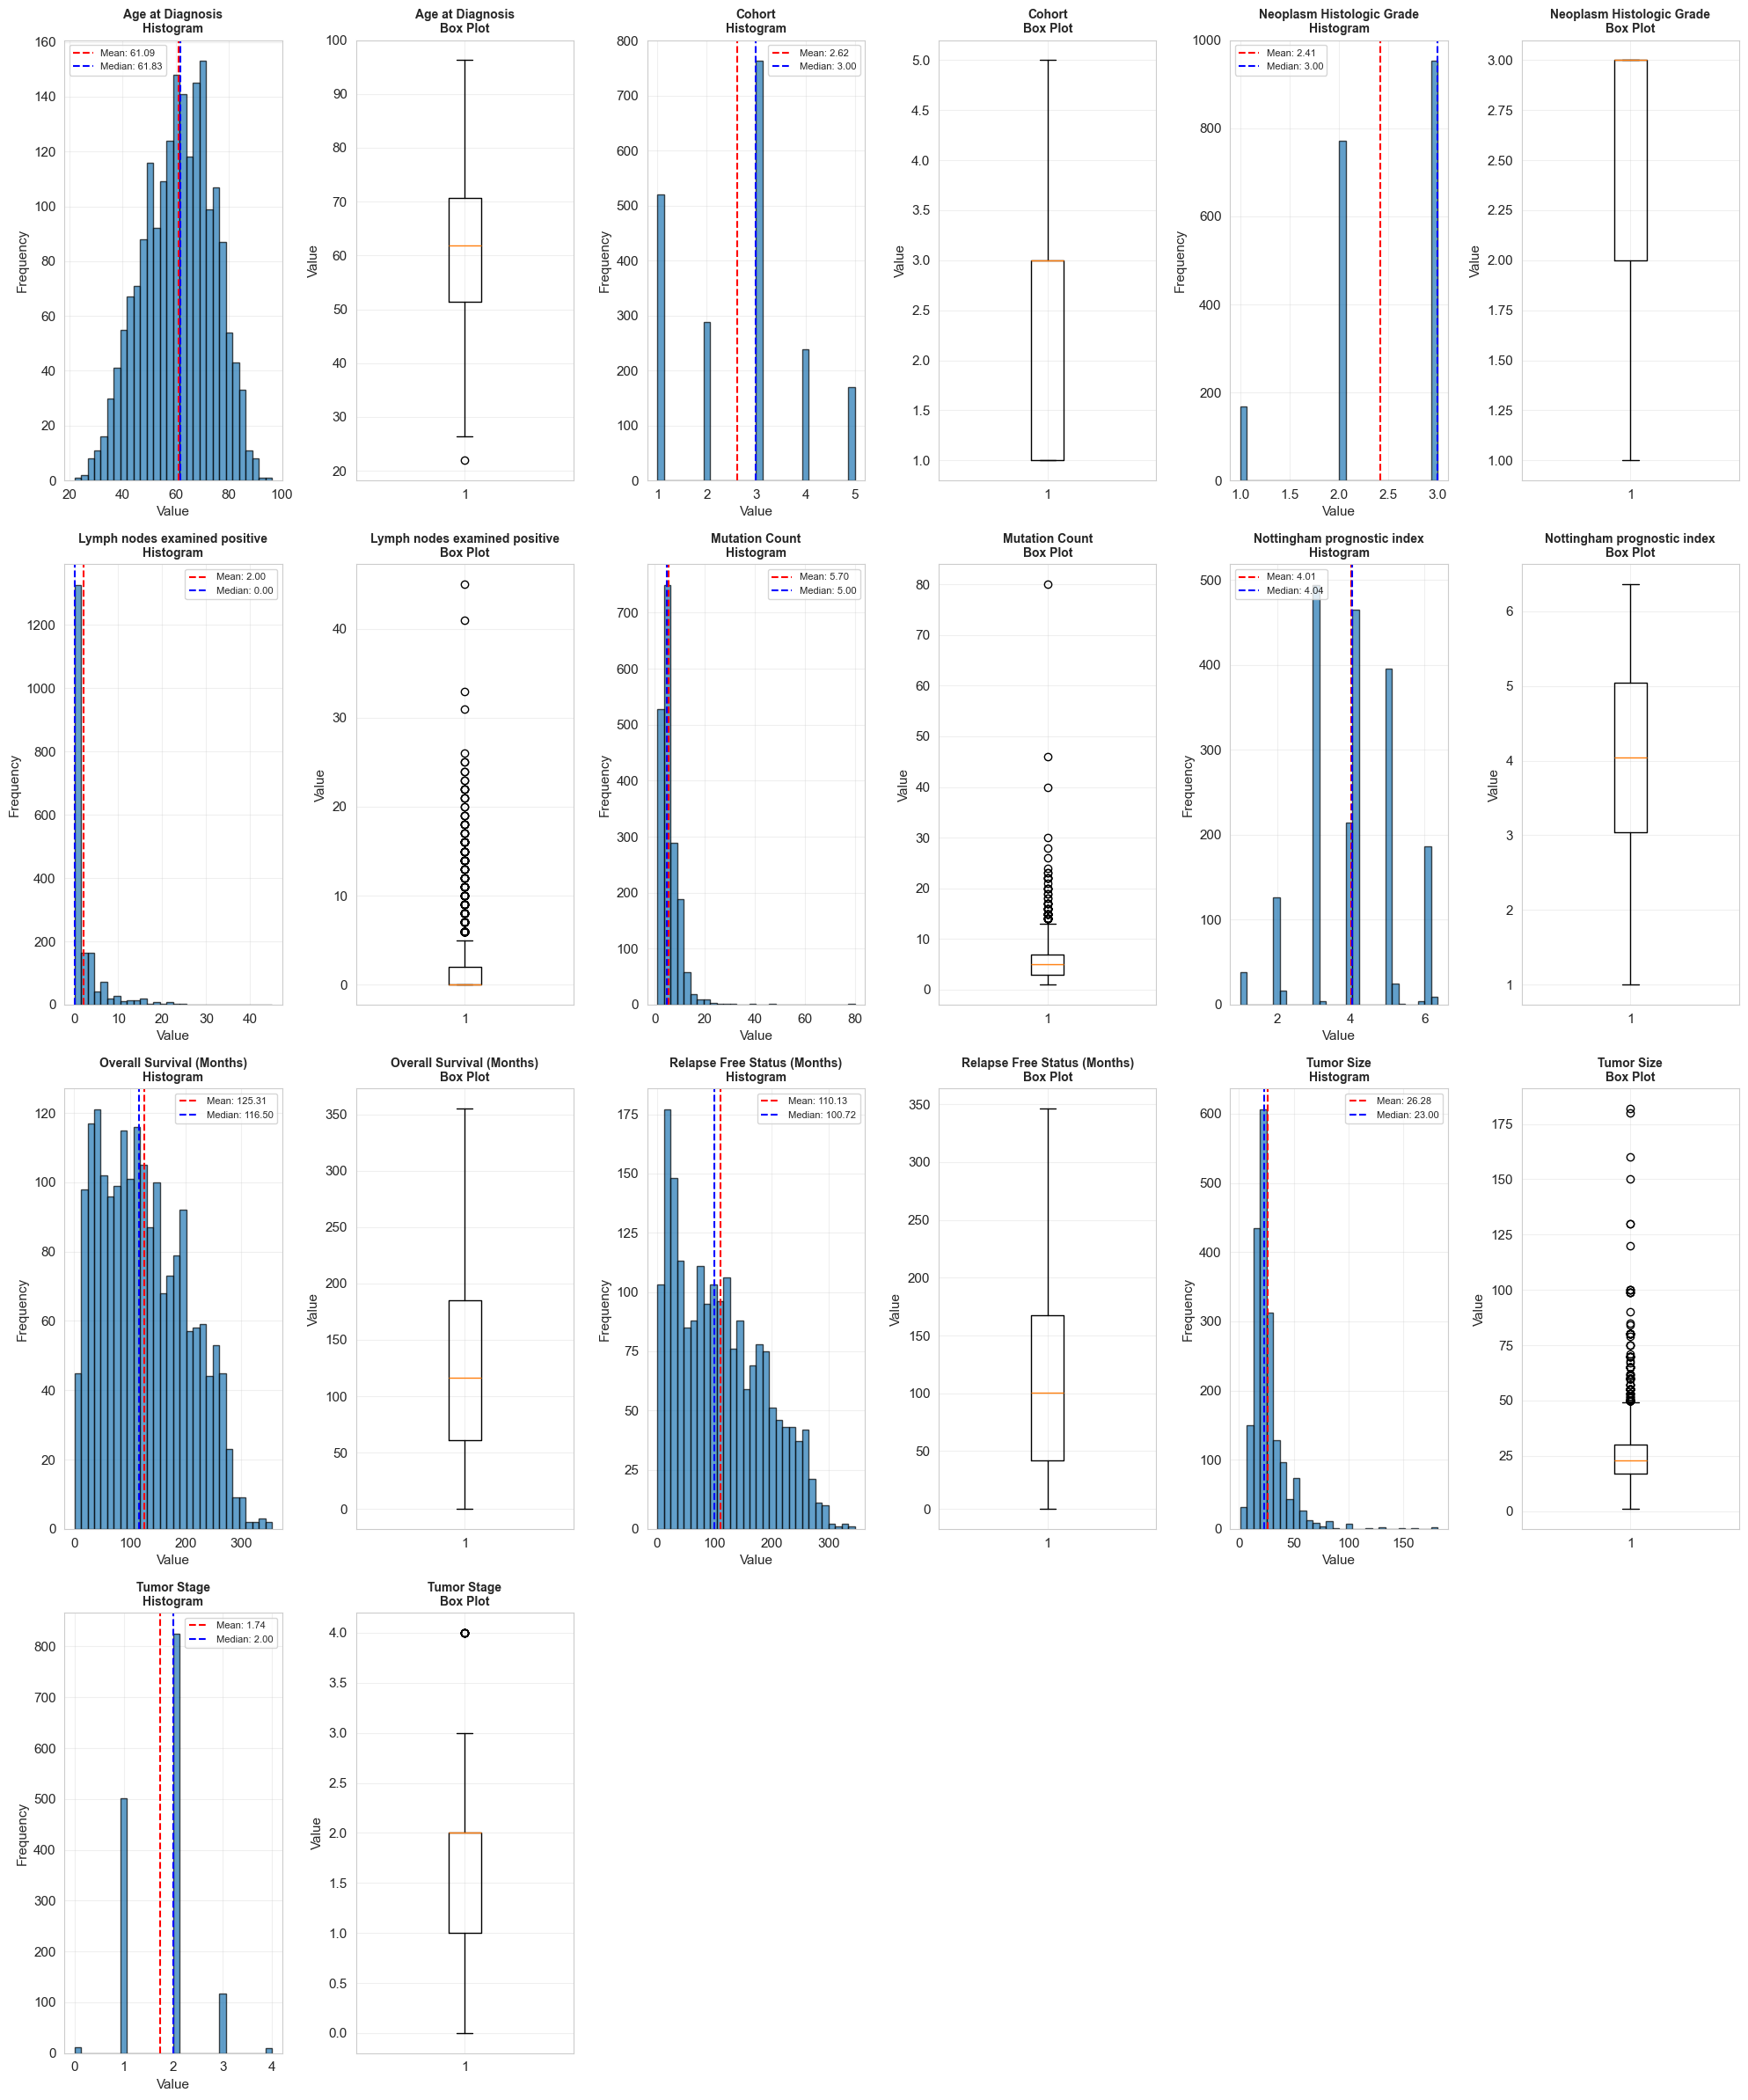


Summary Statistics for Numeric Features:
                                count        mean        std    min        25%      50%         75%     max
Age at Diagnosis               1980.0   61.091869  12.951157  21.93  51.442500   61.825   70.602500   96.29
Cohort                         1980.0    2.620202   1.232127   1.00   1.000000    3.000    3.000000    5.00
Neoplasm Histologic Grade      1893.0    2.414157   0.649158   1.00   2.000000    3.000    3.000000    3.00
Lymph nodes examined positive  1904.0    2.002101   4.079993   0.00   0.000000    0.000    2.000000   45.00
Mutation Count                 1859.0    5.699839   4.057877   1.00   3.000000    5.000    7.000000   80.00
Nottingham prognostic index    1979.0    4.012482   1.160818   1.00   3.044000    4.042    5.040000    6.36
Overall Survival (Months)      1980.0  125.307525  76.078898   0.10  60.891667  116.500  185.141667  355.20
Relapse Free Status (Months)   1980.0  110.128480  76.288336   0.00  41.770000  100.720  167.6

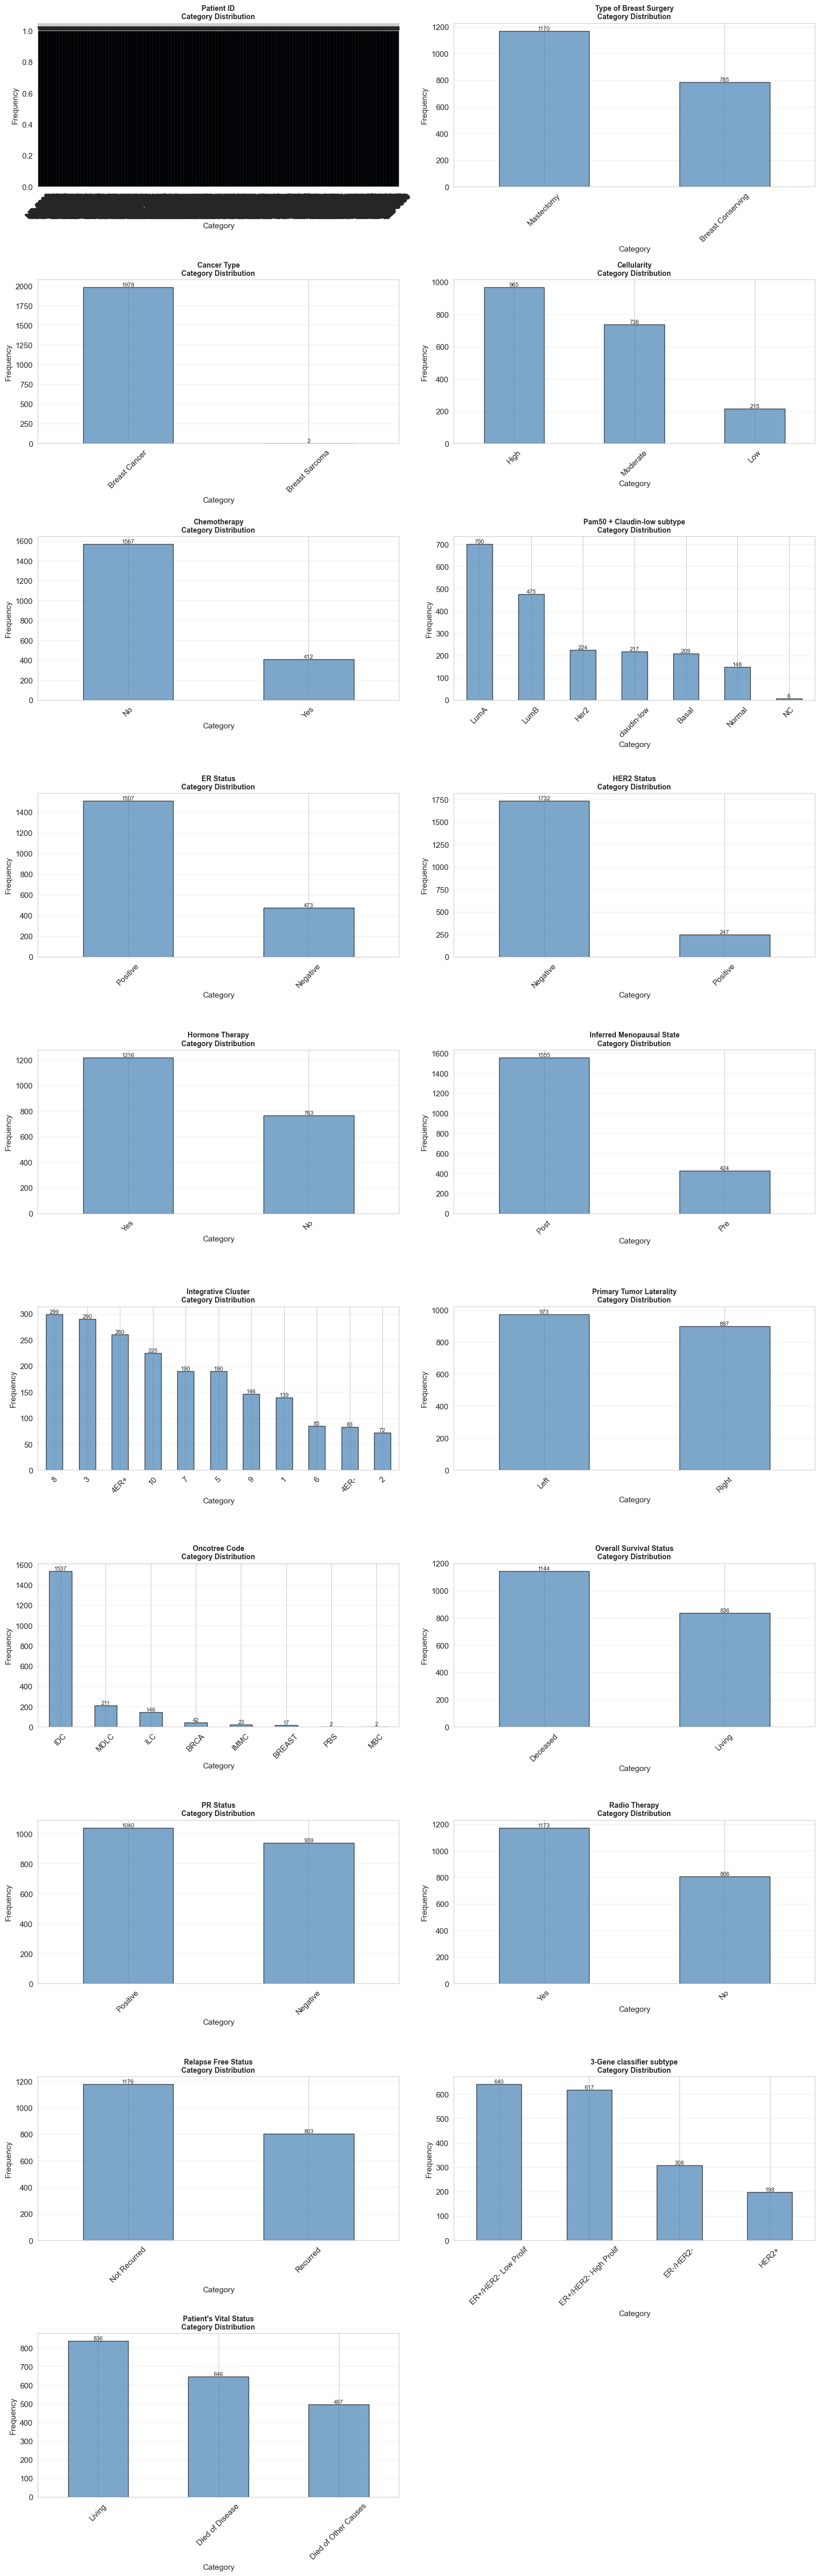


Categorical Feature Summary:

Patient ID:
  Unique values: 1980
  Missing values: 0 (0.00%)
  Most common: MB-0000 (1 occurrences, 0.05%)

Type of Breast Surgery:
  Unique values: 2
  Missing values: 25 (1.26%)
  Most common: Mastectomy (1170 occurrences, 59.09%)
  Value counts:
    Mastectomy: 1170 (59.09%)
    Breast Conserving: 785 (39.65%)

Cancer Type:
  Unique values: 2
  Missing values: 0 (0.00%)
  Most common: Breast Cancer (1978 occurrences, 99.90%)
  Value counts:
    Breast Cancer: 1978 (99.90%)
    Breast Sarcoma: 2 (0.10%)

Cellularity:
  Unique values: 3
  Missing values: 64 (3.23%)
  Most common: High (965 occurrences, 48.74%)
  Value counts:
    High: 965 (48.74%)
    Moderate: 736 (37.17%)
    Low: 215 (10.86%)

Chemotherapy:
  Unique values: 2
  Missing values: 1 (0.05%)
  Most common: No (1567 occurrences, 79.14%)
  Value counts:
    No: 1567 (79.14%)
    Yes: 412 (20.81%)

Pam50 + Claudin-low subtype:
  Unique values: 7
  Missing values: 1 (0.05%)
  Most common: Lu

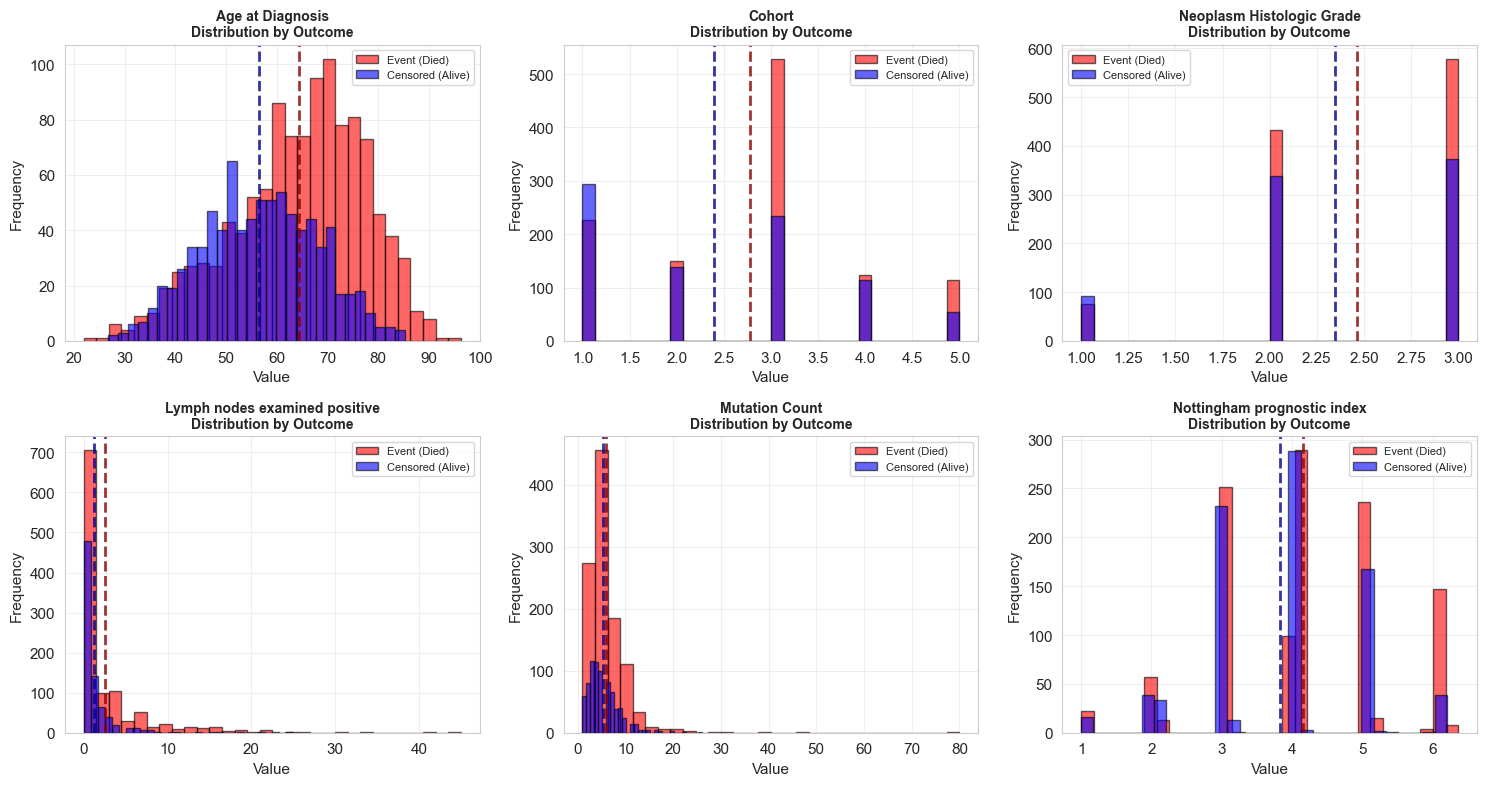


Statistical Comparison (Event vs Censored):
                      Feature  Event_Mean  Censored_Mean  Difference  Difference_%      P_Value Significant
 Relapse Free Status (Months)   83.669292     146.335789  -62.666498    -42.823767 1.349743e-76         Yes
    Overall Survival (Months)  100.443007     159.332656  -58.889649    -36.960188 7.634045e-68         Yes
             Age at Diagnosis   64.443645      56.505227    7.938418     14.048997 3.464594e-45         Yes
                   Tumor Size   28.419140      23.351838    5.067302     21.699800 4.309704e-19         Yes
  Nottingham prognostic index    4.152299       3.821321    0.330978      8.661360 8.104370e-15         Yes
                  Tumor Stage    1.845687       1.595645    0.250041     15.670217 5.577285e-13         Yes
Lymph nodes examined positive    2.571558       1.216250    1.355308    111.433338 1.180244e-12         Yes
                       Cohort    2.782343       2.398325    0.384017     16.011893 5.441317

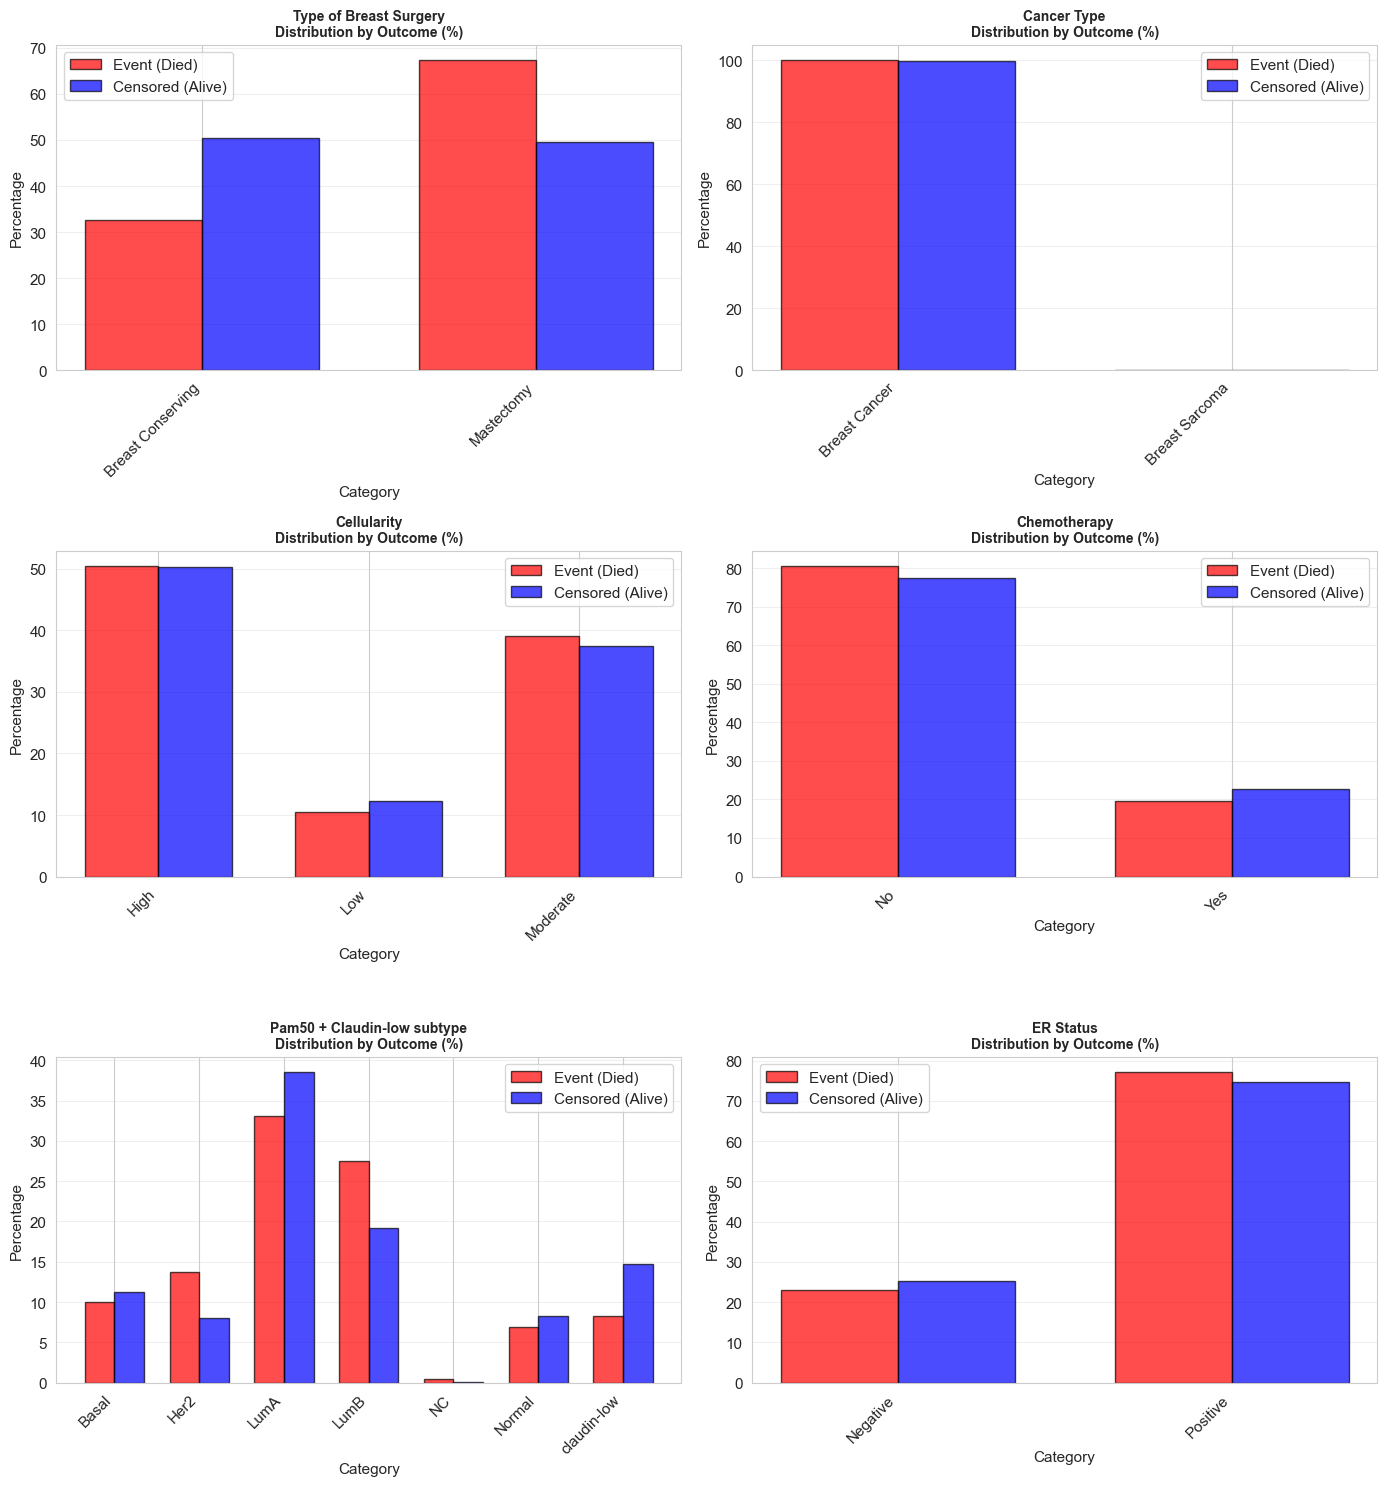


Statistical Comparison (Event vs Censored):
                    Feature  Chi2_Statistic      P_Value Significant
     Type of Breast Surgery       61.559227 4.296235e-15         Yes
Pam50 + Claudin-low subtype       54.228066 6.635756e-10         Yes
               Chemotherapy        2.625715 1.051451e-01          No
                  ER Status        1.325386 2.496277e-01          No
                Cancer Type        0.881710 3.477336e-01          No
                Cellularity        1.917550 3.833623e-01          No

✓ 2 out of 6 categorical features show statistically significant differences (p < 0.05)


In [ ]:
# 3.5.2 Data Distribution Analysis

print("="*60)
print("DATA DISTRIBUTION ANALYSIS")
print("="*60)

# Exclude outcome columns for feature analysis (both original and transformed)
# This prevents data leakage in EDA
outcome_cols = [
    # Transformed outcome columns
    'event_os', 'duration_os', 'event_rfs', 'duration_rfs',
    # Original outcome columns (to prevent leakage)
    'Overall Survival (Months)', 'Overall Survival Status',
    'Relapse Free Status (Months)', 'Relapse Free Status'
]
feature_df = df.drop(columns=[col for col in outcome_cols if col in df.columns], errors='ignore')

# Separate numeric and categorical features
numeric_cols = feature_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = feature_df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nFeature types:")
print(f"  Numeric features: {len(numeric_cols)}")
print(f"  Categorical features: {len(categorical_cols)}")

# 1. Numeric Feature Distributions
print("\n" + "="*60)
print("NUMERIC FEATURE DISTRIBUTIONS")
print("="*60)

if len(numeric_cols) > 0:
    # Calculate number of rows and columns for subplots
    n_numeric = len(numeric_cols)
    n_cols = 3
    n_rows = (n_numeric + n_cols - 1) // n_cols
    
    # Create histograms and box plots for numeric features
    fig, axes = plt.subplots(n_rows, n_cols * 2, figsize=(20, 6 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    axes = axes.flatten()
    
    for idx, col in enumerate(numeric_cols):
        # Histogram
        ax_hist = axes[idx * 2]
        feature_df[col].hist(bins=30, ax=ax_hist, edgecolor='black', alpha=0.7)
        ax_hist.set_title(f'{col}\nHistogram', fontsize=10, fontweight='bold')
        ax_hist.set_xlabel('Value')
        ax_hist.set_ylabel('Frequency')
        ax_hist.grid(True, alpha=0.3)
        
        # Add mean and median lines
        mean_val = feature_df[col].mean()
        median_val = feature_df[col].median()
        ax_hist.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
        ax_hist.axvline(median_val, color='blue', linestyle='--', label=f'Median: {median_val:.2f}')
        ax_hist.legend(fontsize=8)
        
        # Box plot
        ax_box = axes[idx * 2 + 1]
        data_for_boxplot = feature_df[col].dropna().values
        ax_box.boxplot(data_for_boxplot, vert=True)
        ax_box.set_title(f'{col}\nBox Plot', fontsize=10, fontweight='bold')
        ax_box.set_ylabel('Value')
        ax_box.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(numeric_cols) * 2, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics for numeric features
    print("\nSummary Statistics for Numeric Features:")
    print("="*60)
    numeric_summary = feature_df[numeric_cols].describe()
    print(numeric_summary.T.to_string())
    
    # Check for skewed distributions
    print("\n" + "="*60)
    print("SKEWNESS ANALYSIS")
    print("="*60)
    from scipy.stats import skew
    
    skewness_results = []
    for col in numeric_cols:
        if feature_df[col].notna().sum() > 0:
            skew_val = skew(feature_df[col].dropna())
            skewness_results.append({
                'Feature': col,
                'Skewness': skew_val,
                'Interpretation': 'Highly skewed' if abs(skew_val) > 1 else 'Moderately skewed' if abs(skew_val) > 0.5 else 'Approximately normal'
            })
    
    if skewness_results:
        skew_df = pd.DataFrame(skewness_results)
        skew_df = skew_df.sort_values('Skewness', key=abs, ascending=False)
        print(skew_df.to_string(index=False))
        
        # Flag highly skewed features
        highly_skewed = skew_df[skew_df['Skewness'].abs() > 1]
        if len(highly_skewed) > 0:
            print(f"\n⚠ {len(highly_skewed)} features are highly skewed (|skewness| > 1)")
            print("Consider log transformation or other normalization methods.")
else:
    print("No numeric features found.")

# 2. Categorical Feature Distributions
print("\n" + "="*60)
print("CATEGORICAL FEATURE DISTRIBUTIONS")
print("="*60)

if len(categorical_cols) > 0:
    # Calculate number of rows and columns for subplots
    n_categorical = len(categorical_cols)
    n_cols = 2
    n_rows = (n_categorical + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_categorical > 1 else axes.reshape(1, 1)
    axes = axes.flatten()
    
    for idx, col in enumerate(categorical_cols):
        ax = axes[idx]
        value_counts = feature_df[col].value_counts()
        
        # Bar plot
        value_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black', alpha=0.7)
        ax.set_title(f'{col}\nCategory Distribution', fontsize=10, fontweight='bold')
        ax.set_xlabel('Category')
        ax.set_ylabel('Frequency')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add count labels on bars
        for i, v in enumerate(value_counts.values):
            ax.text(i, v, str(v), ha='center', va='bottom', fontsize=8)
    
    # Hide unused subplots
    for idx in range(len(categorical_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Summary for categorical features
    print("\nCategorical Feature Summary:")
    print("="*60)
    for col in categorical_cols:
        n_unique = feature_df[col].nunique()
        n_missing = feature_df[col].isnull().sum()
        most_common = feature_df[col].mode().iloc[0] if len(feature_df[col].mode()) > 0 else 'N/A'
        most_common_count = feature_df[col].value_counts().iloc[0] if len(feature_df[col].value_counts()) > 0 else 0
        most_common_pct = (most_common_count / len(feature_df)) * 100
        
        print(f"\n{col}:")
        print(f"  Unique values: {n_unique}")
        print(f"  Missing values: {n_missing} ({n_missing/len(feature_df)*100:.2f}%)")
        print(f"  Most common: {most_common} ({most_common_count} occurrences, {most_common_pct:.2f}%)")
        
        # Show value counts for features with few categories
        if n_unique <= 10:
            print(f"  Value counts:")
            for val, count in feature_df[col].value_counts().head(10).items():
                pct = (count / len(feature_df)) * 100
                print(f"    {val}: {count} ({pct:.2f}%)")
else:
    print("No categorical features found.")

# 3. Distribution by Outcome (Event vs Censored)
print("\n" + "="*60)
print("DISTRIBUTION BY OUTCOME (Event vs Censored)")
print("="*60)
print("Comparing feature distributions between patients who died (event=1) and those who are still alive (event=0)")

if 'event_os' in df.columns:
    event_group = df[df['event_os'] == 1]
    censored_group = df[df['event_os'] == 0]
    
    print(f"\nGroup sizes:")
    print(f"  Event (died): {len(event_group)} patients")
    print(f"  Censored (alive): {len(censored_group)} patients")
    
    # Compare numeric features by outcome
    if len(numeric_cols) > 0:
        print("\n" + "="*60)
        print("NUMERIC FEATURES: COMPARISON BY OUTCOME")
        print("="*60)
        
        # Select top numeric features for visualization (if too many)
        n_features_to_plot = min(6, len(numeric_cols))
        key_numeric = numeric_cols[:n_features_to_plot]
        
        # Create comparison plots (single row layout)
        n_cols_plot = min(3, n_features_to_plot)
        n_rows_plot = (n_features_to_plot + n_cols_plot - 1) // n_cols_plot
        fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(5 * n_cols_plot, 4 * n_rows_plot))
        if n_rows_plot == 1:
            axes = axes.reshape(1, -1) if n_cols_plot > 1 else axes.reshape(1, 1)
        axes = axes.flatten()
        
        for idx, col in enumerate(key_numeric):
            ax = axes[idx]
            
            # Create overlapping histograms
            event_group[col].dropna().hist(bins=30, ax=ax, alpha=0.6, label='Event (Died)', color='red', edgecolor='black')
            censored_group[col].dropna().hist(bins=30, ax=ax, alpha=0.6, label='Censored (Alive)', color='blue', edgecolor='black')
            ax.set_title(f'{col}\nDistribution by Outcome', fontsize=10, fontweight='bold')
            ax.set_xlabel('Value')
            ax.set_ylabel('Frequency')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
            
            # Add mean lines
            event_mean = event_group[col].mean()
            censored_mean = censored_group[col].mean()
            ax.axvline(event_mean, color='darkred', linestyle='--', linewidth=2, alpha=0.8)
            ax.axvline(censored_mean, color='darkblue', linestyle='--', linewidth=2, alpha=0.8)
        
        # Hide unused subplots
        for idx in range(len(key_numeric), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Statistical comparison for numeric features
        print("\nStatistical Comparison (Event vs Censored):")
        print("="*60)
        comparison_results = []
        
        for col in numeric_cols:
            event_values = event_group[col].dropna()
            censored_values = censored_group[col].dropna()
            
            if len(event_values) > 0 and len(censored_values) > 0:
                from scipy.stats import mannwhitneyu
                
                event_mean = event_values.mean()
                censored_mean = censored_values.mean()
                mean_diff = event_mean - censored_mean
                mean_diff_pct = (mean_diff / censored_mean * 100) if censored_mean != 0 else 0
                
                # Mann-Whitney U test (non-parametric)
                try:
                    statistic, p_value = mannwhitneyu(event_values, censored_values, alternative='two-sided')
                    comparison_results.append({
                        'Feature': col,
                        'Event_Mean': event_mean,
                        'Censored_Mean': censored_mean,
                        'Difference': mean_diff,
                        'Difference_%': mean_diff_pct,
                        'P_Value': p_value,
                        'Significant': 'Yes' if p_value < 0.05 else 'No'
                    })
                except:
                    pass
        
        if comparison_results:
            comparison_df = pd.DataFrame(comparison_results)
            comparison_df = comparison_df.sort_values('P_Value')
            print(comparison_df.to_string(index=False))
            
            # Count significant differences
            n_significant = (comparison_df['P_Value'] < 0.05).sum()
            print(f"\n✓ {n_significant} out of {len(comparison_df)} numeric features show statistically significant differences (p < 0.05)")
    
    # Compare categorical features by outcome
    if len(categorical_cols) > 0:
        print("\n" + "="*60)
        print("CATEGORICAL FEATURES: COMPARISON BY OUTCOME")
        print("="*60)
        
        # Select categorical features with reasonable number of categories
        key_categorical = [col for col in categorical_cols if df[col].nunique() <= 10][:6]
        
        if len(key_categorical) > 0:
            # Create comparison plots
            n_cols = 2
            n_rows = (len(key_categorical) + n_cols - 1) // n_cols
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
            if n_rows == 1:
                axes = axes.reshape(1, -1) if len(key_categorical) > 1 else axes.reshape(1, 1)
            axes = axes.flatten()
            
            for idx, col in enumerate(key_categorical):
                ax = axes[idx]
                
                # Create grouped bar chart
                event_counts = event_group[col].value_counts(normalize=True) * 100
                censored_counts = censored_group[col].value_counts(normalize=True) * 100
                
                # Get all categories
                all_categories = sorted(set(event_counts.index) | set(censored_counts.index))
                
                x = np.arange(len(all_categories))
                width = 0.35
                
                event_values = [event_counts.get(cat, 0) for cat in all_categories]
                censored_values = [censored_counts.get(cat, 0) for cat in all_categories]
                
                ax.bar(x - width/2, event_values, width, label='Event (Died)', color='red', alpha=0.7, edgecolor='black')
                ax.bar(x + width/2, censored_values, width, label='Censored (Alive)', color='blue', alpha=0.7, edgecolor='black')
                
                ax.set_title(f'{col}\nDistribution by Outcome (%)', fontsize=10, fontweight='bold')
                ax.set_xlabel('Category')
                ax.set_ylabel('Percentage')
                ax.set_xticks(x)
                ax.set_xticklabels(all_categories, rotation=45, ha='right')
                ax.legend()
                ax.grid(True, alpha=0.3, axis='y')
            
            # Hide unused subplots
            for idx in range(len(key_categorical), len(axes)):
                axes[idx].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Statistical comparison for categorical features (Chi-square test)
            print("\nStatistical Comparison (Event vs Censored):")
            print("="*60)
            from scipy.stats import chi2_contingency
            
            cat_comparison_results = []
            for col in key_categorical:
                # Create contingency table
                contingency = pd.crosstab(df[col], df['event_os'])
                
                if contingency.shape[0] > 1 and contingency.shape[1] > 1:
                    try:
                        chi2, p_value, dof, expected = chi2_contingency(contingency)
                        cat_comparison_results.append({
                            'Feature': col,
                            'Chi2_Statistic': chi2,
                            'P_Value': p_value,
                            'Significant': 'Yes' if p_value < 0.05 else 'No'
                        })
                    except:
                        pass
            
            if cat_comparison_results:
                cat_comparison_df = pd.DataFrame(cat_comparison_results)
                cat_comparison_df = cat_comparison_df.sort_values('P_Value')
                print(cat_comparison_df.to_string(index=False))
                
                n_significant_cat = (cat_comparison_df['P_Value'] < 0.05).sum()
                print(f"\n✓ {n_significant_cat} out of {len(cat_comparison_df)} categorical features show statistically significant differences (p < 0.05)")


### 3.5.3 Survival Outcome Exploration

**Purpose**: Explore survival outcomes (duration and events) to understand the data structure before Kaplan-Meier analysis.

**What we'll examine:**
- **Survival time distributions**: Histograms and summary statistics for `duration_os`
- **Censoring patterns**: Event vs censored counts and percentages
- **Event rates**: Overall event rate and event rates over time
- **Survival time by outcome**: Compare survival times between event and censored groups
- **Baseline validation**: Verify survival variables are correctly formatted for KM analysis





OVERALL SURVIVAL SUMMARY
Total patients: 1980
Events (died): 1144 (57.8%)
Censored (alive): 836 (42.2%)

Survival Time (duration_os) Statistics:
  Mean: 125.3 months
  Median: 116.5 months
  Min: 0.1 months
  Max: 355.2 months
  IQR: [60.9, 185.1] months

SURVIVAL TIME DISTRIBUTION


/var/folders/s_/c14ll07j3fvb_99plyhxh1m40000gn/T/ipykernel_93590/3679334489.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot(event_data, labels=['Event\n(Died)', 'Censored\n(Alive)'], vert=True)


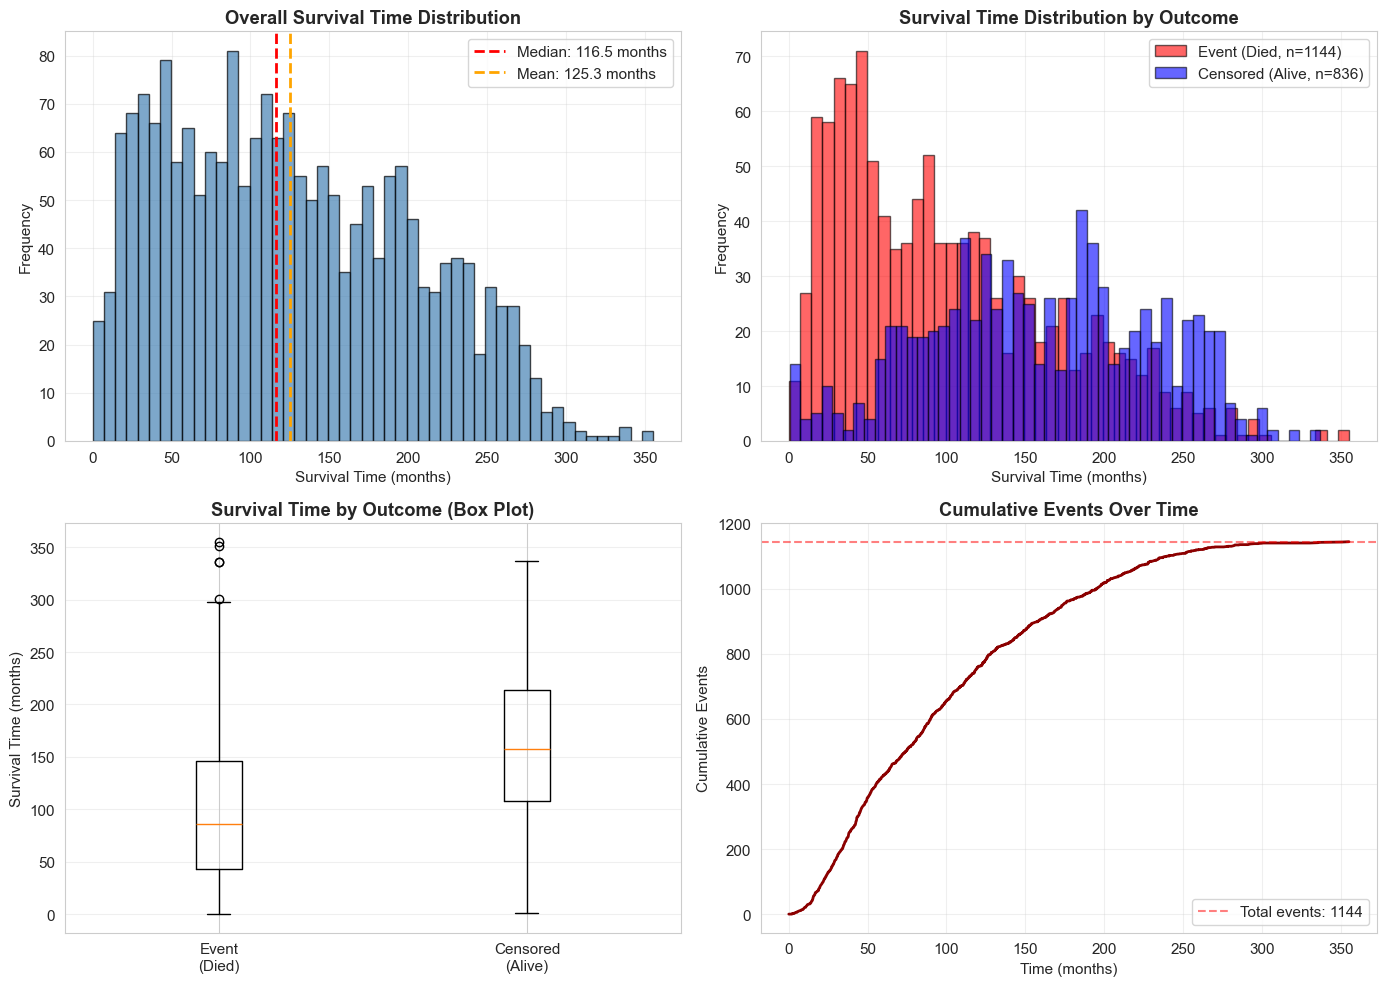


SURVIVAL TIME STATISTICS BY OUTCOME
       Event (Died)  Censored (Alive)  Difference
count   1144.000000        836.000000  308.000000
mean     100.443007        159.332656  -58.889649
std       69.617136         71.256736   -1.639599
min        0.100000          0.766667   -0.666667
25%       42.850000        108.016667  -65.166667
50%       86.066667        157.883333  -71.816667
75%      145.808333        214.100000  -68.291667
max      355.200000        337.033333   18.166667

Mann-Whitney U test (Event vs Censored):
  Statistic: 259502.00
  P-value: 7.63e-68
  Interpretation: Significant difference (p < 0.05)

EVENT RATE BY TIME PERIODS
 Time Period  Patients  Events  Event Rate (%)
 0-12 months        45      30       66.666667
12-24 months       103      90       87.378641
24-36 months       114     103       90.350877
36-60 months       228     204       89.473684
  60+ months      1490     717       48.120805

CENSORING PATTERN ANALYSIS
Censored patients (n=836):
  Mean cens

In [10]:
# 3.5.3 Survival Outcome Exploration

# Verify survival variables exist
if 'event_os' not in df.columns or 'duration_os' not in df.columns:
    raise ValueError("Survival variables (event_os, duration_os) not found in dataframe")

# 1. Overall Survival Summary
print("\n" + "="*60)
print("OVERALL SURVIVAL SUMMARY")
print("="*60)

n_total = len(df)
n_events = df['event_os'].sum()
n_censored = (df['event_os'] == 0).sum()
event_rate = df['event_os'].mean() * 100
censoring_rate = (1 - df['event_os'].mean()) * 100

print(f"Total patients: {n_total}")
print(f"Events (died): {n_events} ({event_rate:.1f}%)")
print(f"Censored (alive): {n_censored} ({censoring_rate:.1f}%)")

# Survival time statistics
print(f"\nSurvival Time (duration_os) Statistics:")
print(f"  Mean: {df['duration_os'].mean():.1f} months")
print(f"  Median: {df['duration_os'].median():.1f} months")
print(f"  Min: {df['duration_os'].min():.1f} months")
print(f"  Max: {df['duration_os'].max():.1f} months")
print(f"  IQR: [{df['duration_os'].quantile(0.25):.1f}, {df['duration_os'].quantile(0.75):.1f}] months")

# 2. Survival Time Distribution Visualization
print("\n" + "="*60)
print("SURVIVAL TIME DISTRIBUTION")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Overall histogram
ax1 = axes[0, 0]
df['duration_os'].hist(bins=50, ax=ax1, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(df['duration_os'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {df["duration_os"].median():.1f} months')
ax1.axvline(df['duration_os'].mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {df["duration_os"].mean():.1f} months')
ax1.set_xlabel('Survival Time (months)')
ax1.set_ylabel('Frequency')
ax1.set_title('Overall Survival Time Distribution', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Distribution by outcome
ax2 = axes[0, 1]
event_times = df[df['event_os'] == 1]['duration_os']
censored_times = df[df['event_os'] == 0]['duration_os']
ax2.hist(event_times, bins=50, alpha=0.6, label=f'Event (Died, n={len(event_times)})', color='red', edgecolor='black')
ax2.hist(censored_times, bins=50, alpha=0.6, label=f'Censored (Alive, n={len(censored_times)})', color='blue', edgecolor='black')
ax2.set_xlabel('Survival Time (months)')
ax2.set_ylabel('Frequency')
ax2.set_title('Survival Time Distribution by Outcome', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Box plot by outcome
ax3 = axes[1, 0]
event_data = [event_times.values, censored_times.values]
ax3.boxplot(event_data, labels=['Event\n(Died)', 'Censored\n(Alive)'], vert=True)
ax3.set_ylabel('Survival Time (months)')
ax3.set_title('Survival Time by Outcome (Box Plot)', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Cumulative events over time
ax4 = axes[1, 1]
# Sort by survival time
df_sorted = df.sort_values('duration_os')
cumulative_events = df_sorted['event_os'].cumsum()
ax4.plot(df_sorted['duration_os'], cumulative_events, linewidth=2, color='darkred')
ax4.set_xlabel('Time (months)')
ax4.set_ylabel('Cumulative Events')
ax4.set_title('Cumulative Events Over Time', fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.axhline(n_events, color='red', linestyle='--', alpha=0.5, label=f'Total events: {n_events}')
ax4.legend()

plt.tight_layout()
plt.show()

# 3. Survival Time Statistics by Outcome
print("\n" + "="*60)
print("SURVIVAL TIME STATISTICS BY OUTCOME")
print("="*60)

event_stats = event_times.describe()
censored_stats = censored_times.describe()

comparison_df = pd.DataFrame({
    'Event (Died)': event_stats,
    'Censored (Alive)': censored_stats
})
comparison_df['Difference'] = comparison_df['Event (Died)'] - comparison_df['Censored (Alive)']

print(comparison_df.to_string())

# Statistical test
from scipy.stats import mannwhitneyu
statistic, p_value = mannwhitneyu(event_times, censored_times, alternative='two-sided')
print(f"\nMann-Whitney U test (Event vs Censored):")
print(f"  Statistic: {statistic:.2f}")
print(f"  P-value: {p_value:.2e}")
print(f"  Interpretation: {'Significant difference' if p_value < 0.05 else 'No significant difference'} (p < 0.05)")

# 4. Event Rate Over Time
print("\n" + "="*60)
print("EVENT RATE BY TIME PERIODS")
print("="*60)

# Define time periods (in months)
time_periods = [
    (0, 12, "0-12 months"),
    (12, 24, "12-24 months"),
    (24, 36, "24-36 months"),
    (36, 60, "36-60 months"),
    (60, float('inf'), "60+ months")
]

period_stats = []
for start, end, label in time_periods:
    if end == float('inf'):
        period_df = df[(df['duration_os'] >= start)]
    else:
        period_df = df[(df['duration_os'] >= start) & (df['duration_os'] < end)]
    
    if len(period_df) > 0:
        n_in_period = len(period_df)
        n_events_in_period = period_df['event_os'].sum()
        event_rate_period = (n_events_in_period / n_in_period) * 100
        
        period_stats.append({
            'Time Period': label,
            'Patients': n_in_period,
            'Events': n_events_in_period,
            'Event Rate (%)': event_rate_period
        })

if period_stats:
    period_df = pd.DataFrame(period_stats)
    print(period_df.to_string(index=False))

# 5. Censoring Pattern Analysis
print("\n" + "="*60)
print("CENSORING PATTERN ANALYSIS")
print("="*60)

# Analyze when censoring occurs
censored_df = df[df['event_os'] == 0]
event_df = df[df['event_os'] == 1]

print(f"Censored patients (n={len(censored_df)}):")
print(f"  Mean censoring time: {censored_df['duration_os'].mean():.1f} months")
print(f"  Median censoring time: {censored_df['duration_os'].median():.1f} months")
print(f"  Min censoring time: {censored_df['duration_os'].min():.1f} months")
print(f"  Max censoring time: {censored_df['duration_os'].max():.1f} months")

print(f"\nEvent patients (n={len(event_df)}):")
print(f"  Mean event time: {event_df['duration_os'].mean():.1f} months")
print(f"  Median event time: {event_df['duration_os'].median():.1f} months")
print(f"  Min event time: {event_df['duration_os'].min():.1f} months")
print(f"  Max event time: {event_df['duration_os'].max():.1f} months")

# Check for immediate events (duration = 0 or very small)
immediate_events = df[(df['event_os'] == 1) & (df['duration_os'] <= 0.1)]
if len(immediate_events) > 0:
    print(f"\n⚠ Warning: {len(immediate_events)} patients have events at time <= 0.1 months")
    print("  These may need special handling in KM analysis")

# 6. Validation Checks
print("\n" + "="*60)
print("VALIDATION CHECKS FOR KM ANALYSIS")
print("="*60)

# Check for negative survival times
negative_times = df[df['duration_os'] < 0]
if len(negative_times) > 0:
    print(f"⚠ Warning: {len(negative_times)} patients have negative survival times")
else:
    print("✓ All survival times are non-negative")

# Check for zero survival times with events
zero_events = df[(df['duration_os'] == 0) & (df['event_os'] == 1)]
if len(zero_events) > 0:
    print(f"⚠ Warning: {len(zero_events)} patients have events at time 0")
    print("  Consider handling these carefully in KM analysis")
else:
    print("✓ No events at time 0")

# Check event indicator is binary
if df['event_os'].isin([0, 1]).all():
    print("✓ Event indicator is binary (0 or 1)")
else:
    print(f"⚠ Warning: Event indicator contains values other than 0 or 1")
    print(f"  Unique values: {df['event_os'].unique()}")

# Check for missing survival data
missing_duration = df['duration_os'].isnull().sum()
missing_event = df['event_os'].isnull().sum()
if missing_duration == 0 and missing_event == 0:
    print("✓ No missing survival data")
else:
    print(f"⚠ Warning: Missing duration: {missing_duration}, Missing event: {missing_event}")

# 7. Key Survival Metrics for KM
print("\n" + "="*60)
print("KEY SURVIVAL METRICS (For KM Analysis)")
print("="*60)

# Calculate potential survival probabilities at key time points (rough estimates)
time_points = [6, 12, 24, 36, 60]  # months
print("\nEstimated survival probabilities at key time points:")
print("(These will be calculated more precisely using KM)")
for t in time_points:
    # Rough estimate: proportion of patients who survived beyond time t
    survived_beyond_t = len(df[(df['duration_os'] > t) | ((df['duration_os'] <= t) & (df['event_os'] == 0))])
    survival_prob = survived_beyond_t / n_total
    print(f"  S({t} months) ≈ {survival_prob:.3f} ({survived_beyond_t}/{n_total} patients)")

# Median survival estimate
median_estimate = df['duration_os'].median()
print(f"\nMedian survival time (approximate): {median_estimate:.1f} months")
print("(Exact median will be calculated using KM)")

print(f"  Total patients: {n_total}")
print(f"  Events: {n_events} ({event_rate:.1f}%)")
print(f"  Censored: {n_censored} ({censoring_rate:.1f}%)")
print(f"\nNote: KM analysis will use the FULL dataset (df), not train/test splits")


MISSING DATA ANALYSIS (Full Dataset)

Total features: 33
Features with missing data: 20
Total missing values: 1250
Total cells: 65340
Missing percentage: 1.91%

FEATURES WITH MISSING DATA
                      Feature  Missing_Count  Missing_Percent Data_Type  Unique_Values
                  Tumor Stage            514        25.959596   float64              5
    3-Gene classifier subtype            217        10.959596    object              4
               Mutation Count            121         6.111111   float64             30
     Primary Tumor Laterality            110         5.555556    object              2
    Neoplasm Histologic Grade             87         4.393939   float64              3
Lymph nodes examined positive             76         3.838384   float64             31
                  Cellularity             64         3.232323    object              3
       Type of Breast Surgery             25         1.262626    object              2
                   Tumor Size

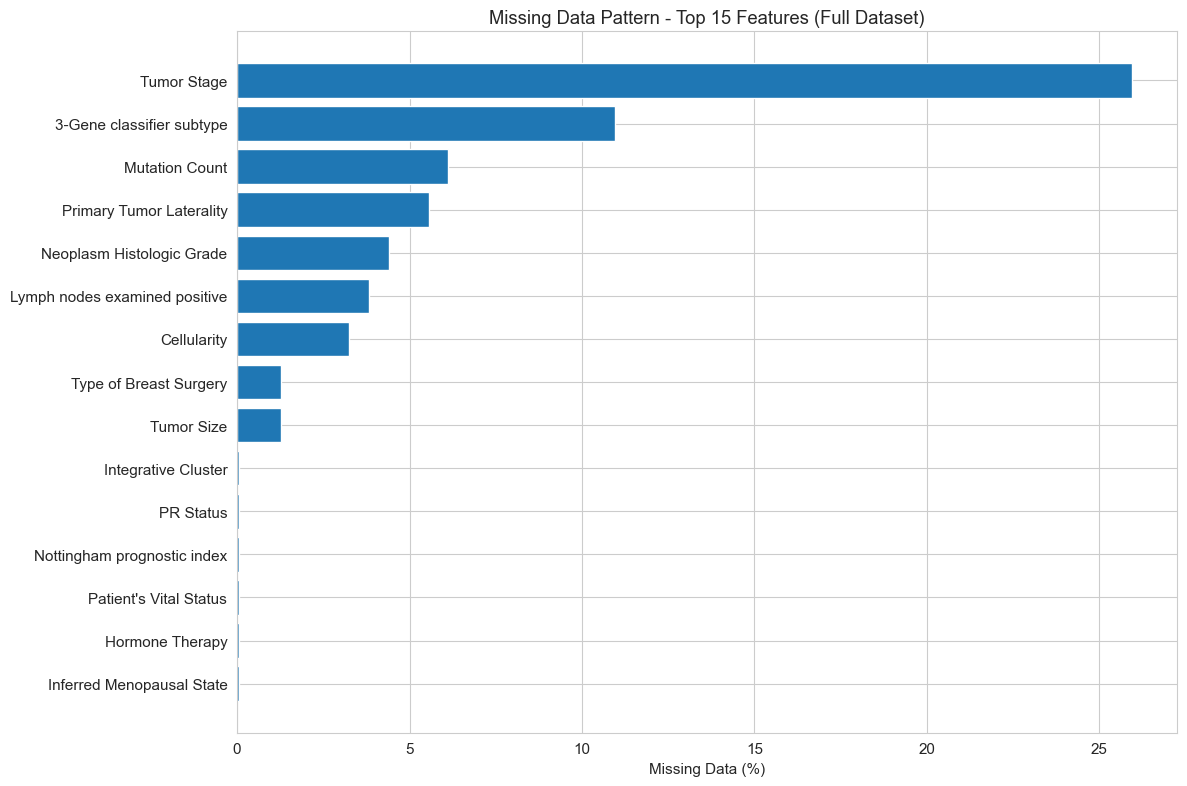


MISSING DATA BY OUTCOME (Informative Missingness Check)
                      Feature  Missing_Event_%  Missing_Censored_%  Difference_%
                  Tumor Stage        28.059441           23.086124      4.973316
    3-Gene classifier subtype        12.325175            9.090909      3.234266
               Mutation Count         4.807692            7.894737      3.087045
     Primary Tumor Laterality         6.818182            3.827751      2.990431
                  Cellularity         2.622378            4.066986      1.444608
    Neoplasm Histologic Grade         4.982517            3.588517      1.394001
Lymph nodes examined positive         3.496503            4.306220      0.809717
       Type of Breast Surgery         1.486014            0.956938      0.529076
                   Tumor Size         1.398601            1.076555      0.322046
          Integrative Cluster         0.087413            0.000000      0.087413

✓ Missing data appears balanced across outcomes


In [ ]:
# 3.5.1 Missing Data Analysis

print("="*60)
print("MISSING DATA ANALYSIS (Full Dataset)")
print("="*60)

# Exclude outcome columns from missing data analysis (both original and transformed)
# This prevents data leakage in EDA
outcome_cols = [
    # Transformed outcome columns
    'event_os', 'duration_os', 'event_rfs', 'duration_rfs',
    # Original outcome columns (to prevent leakage)
    'Overall Survival (Months)', 'Overall Survival Status',
    'Relapse Free Status (Months)', 'Relapse Free Status'
]
feature_df = df.drop(columns=[col for col in outcome_cols if col in df.columns], errors='ignore')

# Calculate missing data statistics for features only (excluding outcomes)
missing_stats = pd.DataFrame({
    'Feature': feature_df.columns,
    'Missing_Count': feature_df.isnull().sum(),
    'Missing_Percent': (feature_df.isnull().sum() / len(feature_df) * 100),
    'Data_Type': feature_df.dtypes,
    'Unique_Values': [feature_df[col].nunique() for col in feature_df.columns]
})

# Sort by missing percentage
missing_stats = missing_stats.sort_values('Missing_Percent', ascending=False)

print(f"\nTotal features (excluding outcomes): {len(feature_df.columns)}")
print(f"Features with missing data: {(missing_stats['Missing_Percent'] > 0).sum()}")
print(f"Total missing values: {missing_stats['Missing_Count'].sum()}")
print(f"Total cells: {len(feature_df) * len(feature_df.columns)}")
print(f"Missing percentage: {(missing_stats['Missing_Count'].sum() / (len(feature_df) * len(feature_df.columns)) * 100):.2f}%")

# Display features with missing data
print("\n" + "="*60)
print("FEATURES WITH MISSING DATA")
print("="*60)
features_with_missing = missing_stats[missing_stats['Missing_Percent'] > 0]
if len(features_with_missing) > 0:
    print(features_with_missing.to_string(index=False))
else:
    print("No missing data found!")

# Visualize missing data pattern
if len(features_with_missing) > 0:
    plt.figure(figsize=(12, 8))
    top_missing = features_with_missing.head(15)
    plt.barh(range(len(top_missing)), top_missing['Missing_Percent'].values)
    plt.yticks(range(len(top_missing)), top_missing['Feature'].values)
    plt.xlabel('Missing Data (%)')
    plt.title('Missing Data Pattern - Top 15 Features (Full Dataset)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Check if missingness is related to outcome (informative missingness)
# Note: We use event_os as a grouping variable (not as a feature) to compare missingness
print("\n" + "="*60)
print("MISSING DATA BY OUTCOME (Informative Missingness Check)")
print("="*60)
if len(features_with_missing) > 0:
    missing_by_outcome = []
    # features_with_missing already excludes outcome columns (from feature_df)
    for col in features_with_missing['Feature'].head(10):
        # Use df to access event_os for grouping, but col is from feature_df (no outcome columns)
        missing_event = df.loc[df['event_os'] == 1, col].isnull().mean() * 100
        missing_censored = df.loc[df['event_os'] == 0, col].isnull().mean() * 100
        missing_by_outcome.append({
            'Feature': col,
            'Missing_Event_%': missing_event,
            'Missing_Censored_%': missing_censored,
            'Difference_%': abs(missing_event - missing_censored)
        })
    
    if missing_by_outcome:
        missing_outcome_df = pd.DataFrame(missing_by_outcome)
        missing_outcome_df = missing_outcome_df.sort_values('Difference_%', ascending=False)
        print(missing_outcome_df.to_string(index=False))
        
        # Flag features with differential missingness
        threshold = 5.0  # 5% difference
        differential_missing = missing_outcome_df[missing_outcome_df['Difference_%'] > threshold]
        if len(differential_missing) > 0:
            print(f"\n⚠ WARNING: {len(differential_missing)} features show differential missingness (>5% difference)")
            print("This may indicate informative missingness or potential bias.")
        else:
            print("\n✓ Missing data appears balanced across outcomes")


## 4. Kaplan-Meier Survival Analysis

**Purpose**: Estimate survival probabilities and create survival curves using the Kaplan-Meier method.

**What we'll do:**
- **Overall KM curve**: Estimate survival probabilities for the entire cohort
- **Stratified KM curves**: Compare survival across different subgroups (e.g., by tumor stage, treatment)
- **Survival statistics**: Calculate median survival, survival probabilities at key time points
- **Log-rank tests**: Statistically compare survival curves between groups


### 4.1 Overall Kaplan-Meier Survival Curve

Estimate the overall survival function for the entire cohort.


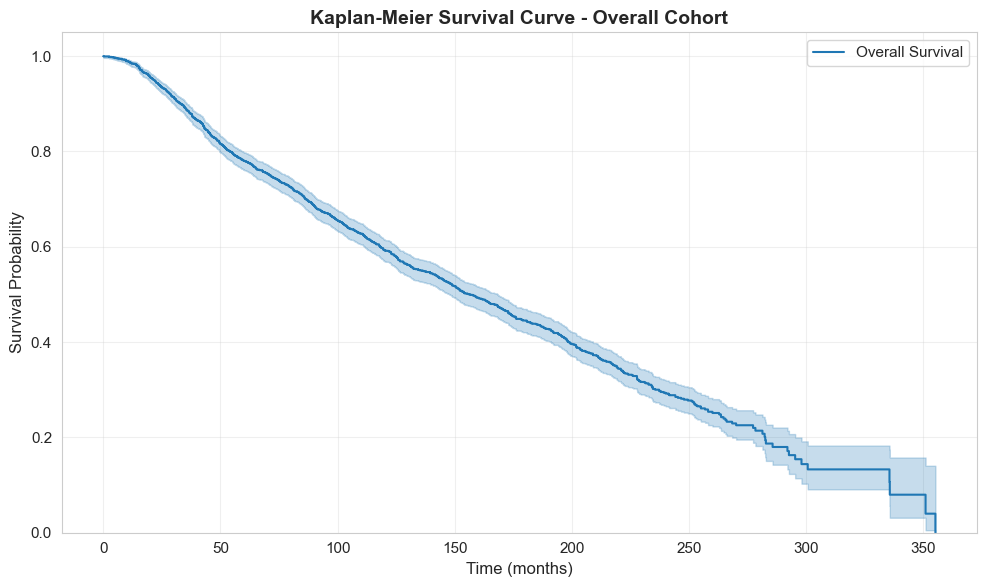


SURVIVAL STATISTICS
Median survival time: 156.3 months

Survival probabilities at key time points:
  S(6 months) = 0.995
  S(12 months) = 0.985
  S(24 months) = 0.939
  S(36 months) = 0.886
  S(60 months) = 0.780

Total patients: 1980
Events (deaths): 1144 (57.8%)
Censored: 836 (42.2%)

Restricted Mean Survival Time (RMST):
 t0 [months]  RMST [months]
          12           11.9
          24           23.5
          36           34.5
          60           54.4
         120           95.7


In [ ]:
# 4.1 Overall Kaplan-Meier Survival Curve

# Fit KM on the full dataset
km = KaplanMeierFitter(label="Overall Survival")

# Ensure survival times are non-negative
df_km = df.copy()
df_km['duration_os'] = df_km['duration_os'].clip(lower=0)

# Fit the KM estimator
km.fit(durations=df_km['duration_os'], event_observed=df_km['event_os'])

# Plot the survival curve
fig, ax = plt.subplots(figsize=(10, 6))
km.plot_survival_function(ax=ax, ci_show=True)
ax.set_xlabel('Time (months)', fontsize=12)
ax.set_ylabel('Survival Probability', fontsize=12)
ax.set_title('Kaplan-Meier Survival Curve - Overall Cohort', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.show()

# Print survival statistics
print("\n" + "="*60)
print("SURVIVAL STATISTICS")
print("="*60)

# Calculate and print the median survival time
median_survival_time = km.median_survival_time_
print(f"Median survival time: {median_survival_time:.1f} months")

# Survival probabilities at key time points
time_points = [6, 12, 24, 36, 60]  # months
print(f"\nSurvival probabilities at key time points:")
for t in time_points:
    survival_prob = km.predict(t)
    # Get confidence interval if available
    try:
        ci = km.confidence_interval_
        if t <= ci.index.max():
            ci_lower = ci.loc[ci.index <= t, 'lower_bound'].iloc[-1] if len(ci.loc[ci.index <= t]) > 0 else None
            ci_upper = ci.loc[ci.index <= t, 'upper_bound'].iloc[-1] if len(ci.loc[ci.index <= t]) > 0 else None
            if ci_lower is not None and ci_upper is not None:
                print(f"  S({t} months) = {survival_prob:.3f} (95% CI: [{ci_lower:.3f}, {ci_upper:.3f}])")
            else:
                print(f"  S({t} months) = {survival_prob:.3f}")
        else:
            print(f"  S({t} months) = {survival_prob:.3f}")
    except:
        print(f"  S({t} months) = {survival_prob:.3f}")

# Summary statistics
print(f"\nTotal patients: {len(df_km)}")
print(f"Events (deaths): {df_km['event_os'].sum()} ({df_km['event_os'].mean()*100:.1f}%)")
print(f"Censored: {(df_km['event_os'] == 0).sum()} ({(df_km['event_os'] == 0).mean()*100:.1f}%)")

# Restricted Mean Survival Time (RMST)
horizons = [12.0, 24.0, 36.0, 60.0, 120.0]  # months

rows = []
for t0 in horizons:
    rmst_val = restricted_mean_survival_time(km, t=t0)
    rows.append({"t0 [months]": int(t0), "RMST [months]": round(float(rmst_val), 1)})

rmst_table = pd.DataFrame(rows)
print("\nRestricted Mean Survival Time (RMST):")
print(rmst_table.to_string(index=False))




The decline is gradual and roughly linear on the probability scale from 0 → 300 months, indicating deaths are distributed across long follow-up rather than concentrated in a short period.
- No abrupt early drop — short-term survival is good.
- Median ~10 years indicates long-term survivorship; clinical focus should include long-term follow-up because mortality accumulates over decades.

### 4.2 Relapse-Free Survival (RFS) Kaplan-Meier Curve


RELAPSE-FREE SURVIVAL (RFS) KAPLAN-MEIER ANALYSIS

RFS data available: 1980 patients
Events (recurrences): 803 (40.6%)
Censored (no recurrence): 1177 (59.4%)


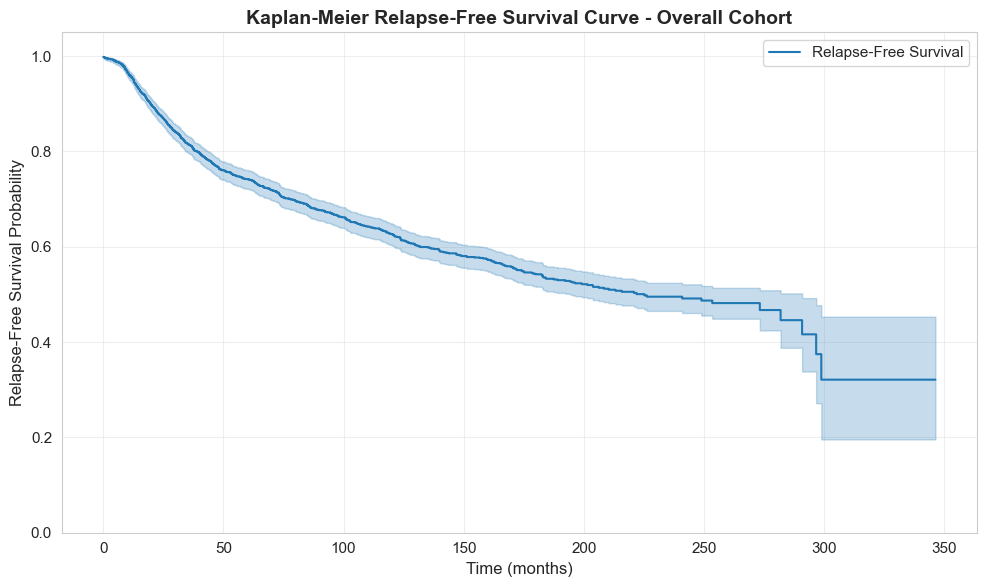


Median relapse-free survival time: 225.2 months

Restricted Mean Relapse-Free Survival Time (RMST):
 t0 [months]  RMST [months]
          12           11.8
          24           22.7
          36           32.8
          60           51.3
         120           92.1


In [14]:
# 4.2 Relapse-Free Survival (RFS) Kaplan-Meier Curve

# Check if RFS data is available
if 'event_rfs' in df.columns and 'duration_rfs' in df.columns:
    print("="*60)
    print("RELAPSE-FREE SURVIVAL (RFS) KAPLAN-MEIER ANALYSIS")
    print("="*60)
    
    # Fit KM on RFS data
    km_rfs = KaplanMeierFitter(label="Relapse-Free Survival")
    
    # Ensure survival times are non-negative
    df_rfs = df[df['duration_rfs'].notna()].copy()
    df_rfs['duration_rfs'] = df_rfs['duration_rfs'].clip(lower=0)
    
    print(f"\nRFS data available: {len(df_rfs)} patients")
    print(f"Events (recurrences): {df_rfs['event_rfs'].sum()} ({df_rfs['event_rfs'].mean()*100:.1f}%)")
    print(f"Censored (no recurrence): {(df_rfs['event_rfs'] == 0).sum()} ({(df_rfs['event_rfs'] == 0).mean()*100:.1f}%)")
    
    # Fit the KM estimator
    km_rfs.fit(durations=df_rfs['duration_rfs'], event_observed=df_rfs['event_rfs'])
    
    # Plot the survival curve
    fig, ax = plt.subplots(figsize=(10, 6))
    km_rfs.plot_survival_function(ax=ax, ci_show=True)
    ax.set_xlabel('Time (months)', fontsize=12)
    ax.set_ylabel('Relapse-Free Survival Probability', fontsize=12)
    ax.set_title('Kaplan-Meier Relapse-Free Survival Curve - Overall Cohort', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    plt.tight_layout()
    plt.show()
    
    # Calculate and print the median RFS time
    median_rfs_time = km_rfs.median_survival_time_
    print(f"\nMedian relapse-free survival time: {median_rfs_time:.1f} months")
    
    # Restricted Mean Survival Time (RMST) for RFS
    horizons = [12.0, 24.0, 36.0, 60.0, 120.0]  # months
    
    rows = []
    for t0 in horizons:
        rmst_val = restricted_mean_survival_time(km_rfs, t=t0)
        rows.append({"t0 [months]": int(t0), "RMST [months]": round(float(rmst_val), 1)})
    
    rmst_table_rfs = pd.DataFrame(rows)
    print("\nRestricted Mean Relapse-Free Survival Time (RMST):")
    print(rmst_table_rfs.to_string(index=False))
    
    
else:
    print("RFS data not available in the dataset.")
    print("Only Overall Survival (OS) analysis will be performed.")


The relapse-free survival curve experences a sharp drop within the first 50 months, suggesting a higher risk of relaps during the early stage. Beyond this point, the curve flattens, indicating a slower rate of decline in relapse-free probability over long term. The relapse-free survival curve falls to 0.5 between 200 and 250 months. After 270 months, the probability of remaining relapse-free declines further to around 0.3.

Clinical meaning:
Interventions aimed at reducing recurrence should target earlier time windows (first 5–10 years).

### 4.3 Cumulative Incidence Curves and Nelson-Aalen Cumulative Hazard


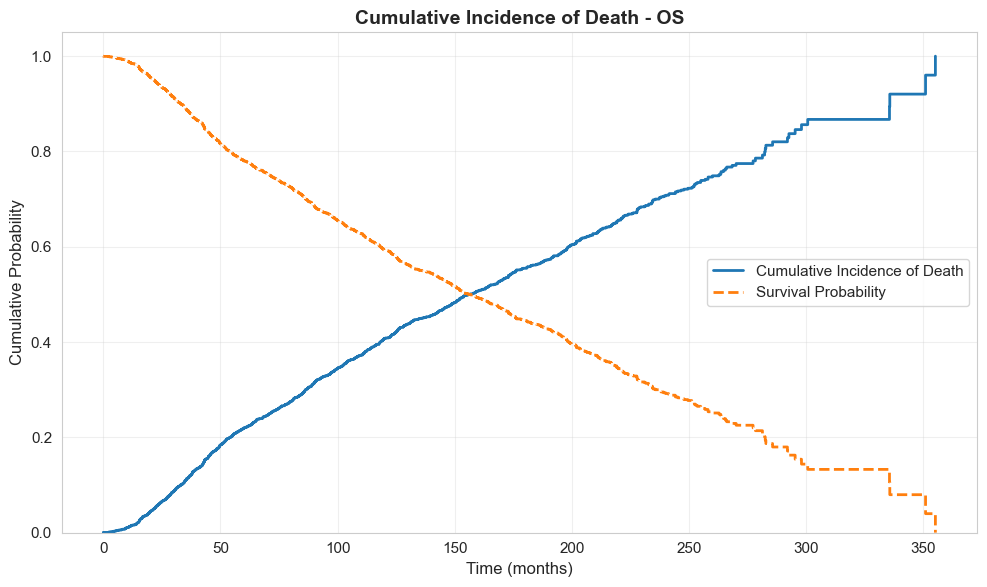

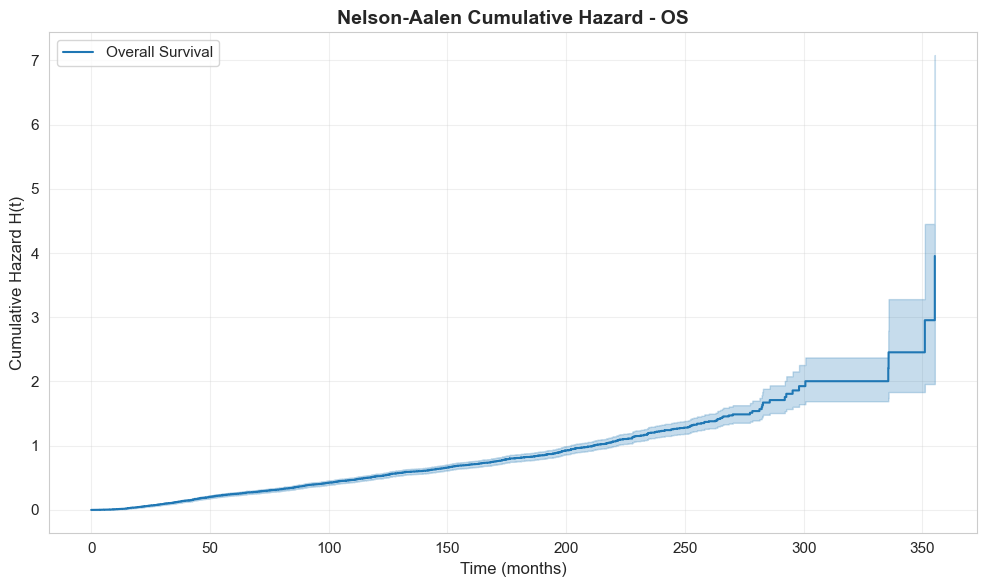

In [24]:
# 4.3.1 Cumulative Incidence Curves - OS

# Cumulative incidence = 1 - Survival probability
survival_func = km.survival_function_
survival_probs = survival_func.iloc[:, 0].values
cumulative_incidence = 1 - survival_probs
times = survival_func.index.values

fig, ax = plt.subplots(figsize=(10, 6))
ax.step(times, cumulative_incidence, where='post', label='Cumulative Incidence of Death', linewidth=2)
ax.step(times, survival_probs, where='post', label='Survival Probability', linewidth=2, linestyle='--')
ax.set_xlabel('Time (months)', fontsize=12)
ax.set_ylabel('Cumulative Probability', fontsize=12)
ax.set_title('Cumulative Incidence of Death - OS', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.show()

#  Nelson-Aalen Cumulative Hazard - OS

naf_os = NelsonAalenFitter(label="Overall Survival")
naf_os.fit(durations=df_km['duration_os'], event_observed=df_km['event_os'])

fig, ax = plt.subplots(figsize=(10, 6))
naf_os.plot_cumulative_hazard(ax=ax, ci_show=True)
ax.set_xlabel('Time (months)', fontsize=12)
ax.set_ylabel('Cumulative Hazard H(t)', fontsize=12)
ax.set_title('Nelson-Aalen Cumulative Hazard - OS', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


The Nelson–Aalen cumulative hazard curve showed a gradual accumulation of mortality risk over time, with a sharp increase in hazard after ~300 months; widening confidence intervals reflect fewer patients remaining in follow-up at later time points.

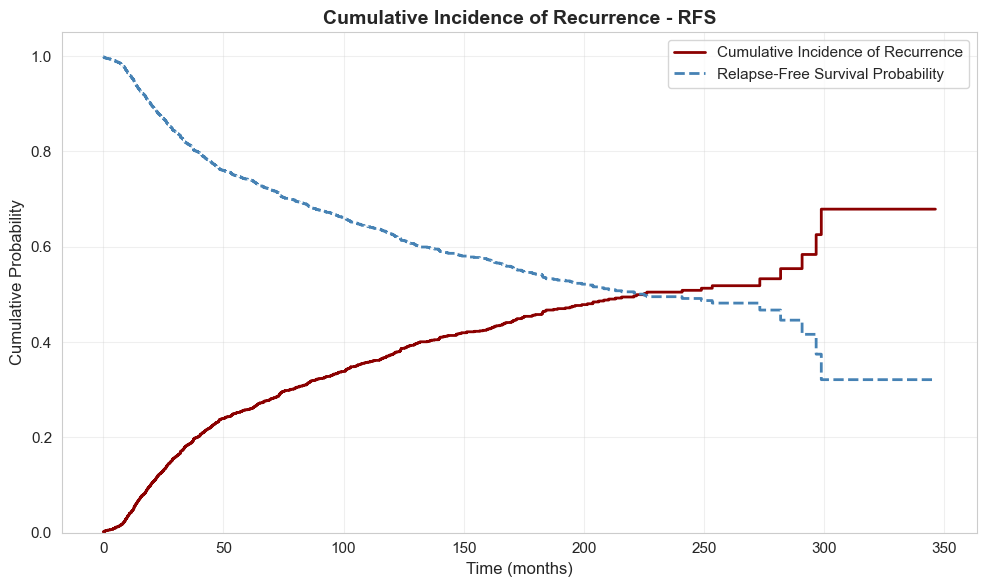

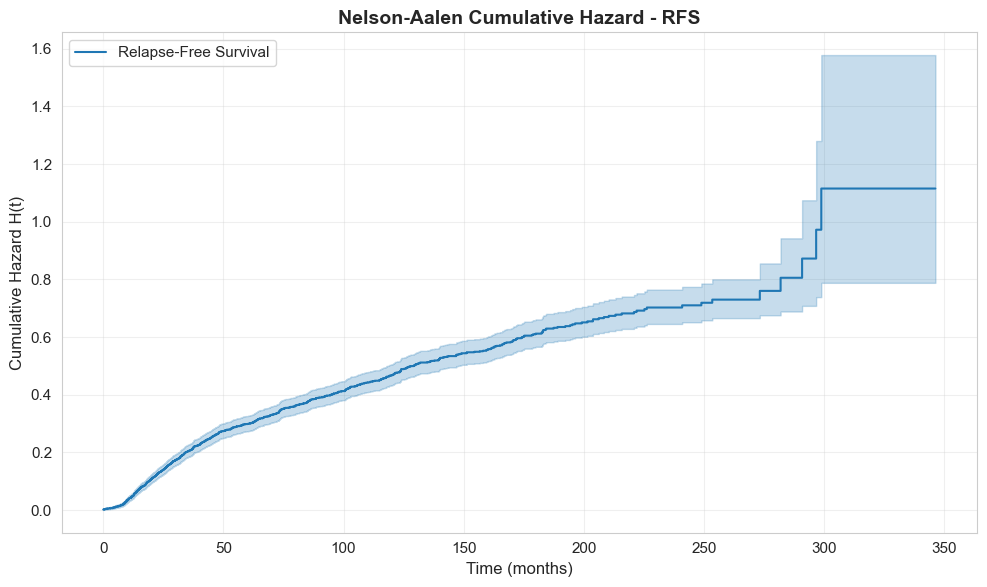

In [ ]:
# 4.3.2 Cumulative Incidence and Nelson-Aalen - RFS

if 'event_rfs' in df.columns and 'duration_rfs' in df.columns:
    # Prepare RFS data
    df_rfs = df[df['duration_rfs'].notna()].copy()
    df_rfs['duration_rfs'] = df_rfs['duration_rfs'].clip(lower=0)
    
    # Fit KM for RFS if not already fitted (from section 4.2)
    try:
        km_rfs
    except NameError:
        km_rfs = KaplanMeierFitter(label="Relapse-Free Survival")
        km_rfs.fit(durations=df_rfs['duration_rfs'], event_observed=df_rfs['event_rfs'])
    
    # Cumulative Incidence for RFS
    survival_func_rfs = km_rfs.survival_function_
    survival_probs_rfs = survival_func_rfs.iloc[:, 0].values
    cumulative_incidence_rfs = 1 - survival_probs_rfs
    times_rfs = survival_func_rfs.index.values
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.step(times_rfs, cumulative_incidence_rfs, where='post', label='Cumulative Incidence of Recurrence', 
            linewidth=2, color='darkred')
    ax.step(times_rfs, survival_probs_rfs, where='post', label='Relapse-Free Survival Probability', 
            linewidth=2, linestyle='--', color='steelblue')
    ax.set_xlabel('Time (months)', fontsize=12)
    ax.set_ylabel('Cumulative Probability', fontsize=12)
    ax.set_title('Cumulative Incidence of Recurrence - RFS', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    plt.tight_layout()
    plt.show()
    
    # Nelson-Aalen for RFS
    naf_rfs = NelsonAalenFitter(label="Relapse-Free Survival")
    naf_rfs.fit(durations=df_rfs['duration_rfs'], event_observed=df_rfs['event_rfs'])
    
    fig, ax = plt.subplots(figsize=(10, 6))
    naf_rfs.plot_cumulative_hazard(ax=ax, ci_show=True)
    ax.set_xlabel('Time (months)', fontsize=12)
    ax.set_ylabel('Cumulative Hazard H(t)', fontsize=12)
    ax.set_title('Nelson-Aalen Cumulative Hazard - RFS', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("RFS data not available.")


Early in follow-up, few relapses occurred, but the rate rose gradually. By about 300 months, the cumulative incidence of recurrence reached ~68%, meaning nearly two-thirds of patients had relapsed. At the same time, relapse-free survival dropped to ~32%. The Nelson–Aalen curve showed a steadily increasing cumulative hazard, indicating that the risk of recurrence continues to build over time and does not level off.

- Clearly shows how recurrence probability builds: ~0 at baseline → ~0.5 around ~220 months → ~0.68 at ~300 months.
- Early-to-mid follow-up is the highest-action window for preventing recurrence; however, risk persists long-term.

### 4.4 Subgroup Comparisons with Log-Rank Tests




In [47]:
# 4.4.1 Helper function for subgroup Kaplan-Meier curves with log-rank tests

from lifelines.statistics import logrank_test, multivariate_logrank_test

def km_by_group(df, group_col, time_col='duration_os', event_col='event_os', 
                title=None, min_group_size=5, label_map=None):
    """Create KM curves by group and perform log-rank test."""

    # Filter and get valid groups
    d = df[[group_col, time_col, event_col]].dropna()
    groups = [g for g in sorted(d[group_col].unique()) 
              if len(d[d[group_col] == g]) >= min_group_size]
    
    if len(groups) < 2:
        print(f"⚠ Not enough groups (min={min_group_size}) for {group_col}")
        return None, None
    
    # Plot KM curves
    fig, ax = plt.subplots(figsize=(10, 6))
    for g in groups:
        d_g = d[d[group_col] == g]
        label = label_map.get(g, str(g)) if label_map else str(g)
        km = KaplanMeierFitter(label=label)
        km.fit(durations=d_g[time_col], event_observed=d_g[event_col])
        km.plot_survival_function(ax=ax, ci_show=True)
    
    ax.set_xlabel('Time (months)', fontsize=12)
    ax.set_ylabel('Survival Probability', fontsize=12)
    ax.set_title(title or f'Survival by {group_col}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    plt.tight_layout()
    plt.show()
    
    # Log-rank test
    if len(groups) == 2:
        d1, d2 = d[d[group_col] == groups[0]], d[d[group_col] == groups[1]]
        result = logrank_test(d1[time_col], d2[time_col],
                             event_observed_A=d1[event_col], event_observed_B=d2[event_col])
        test_type = "Log-rank"
    else:
        result = multivariate_logrank_test(d[time_col], groups=d[group_col], 
                                          event_observed=d[event_col])
        test_type = "Multigroup log-rank"
    
    p = result.p_value
    sig = "Highly significant" if p < 0.001 else "Very significant" if p < 0.01 else \
          "Significant" if p < 0.05 else "Not significant"
    print(f"{test_type} test: p = {p:.6f} ({sig})")
    
    return fig, result





ER Status distribution:
ER Status
Positive    1507
Negative     473
Name: count, dtype: int64


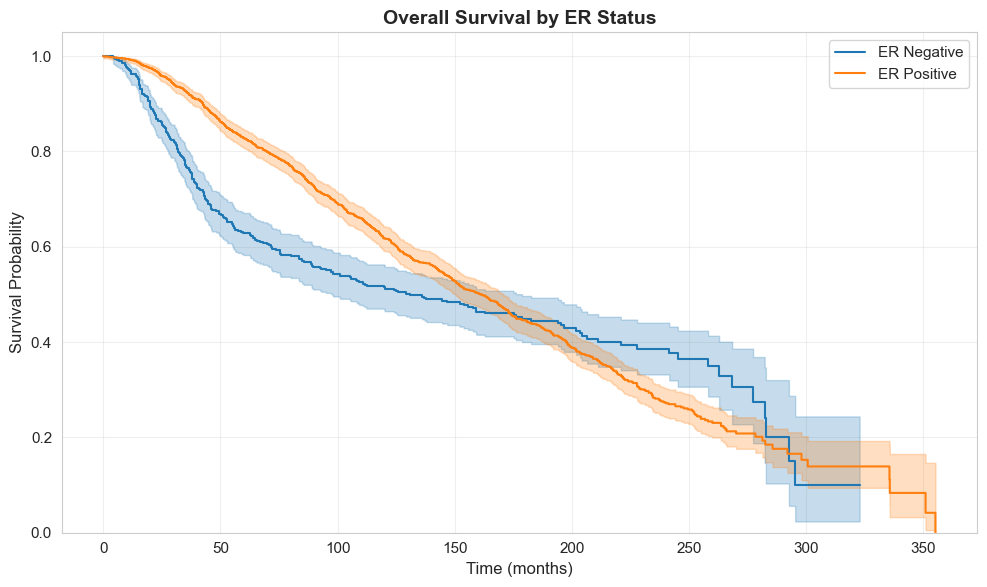

Log-rank test p-value: 0.035047
  → Significant difference (p < 0.05)


In [46]:
# 4.4.2 ER Status Comparison - Overall Survival (OS)

if 'ER Status' in df.columns:
    
    # Check value counts
    print(f"\nER Status distribution:")
    print(df['ER Status'].value_counts())
    
    # Create Kaplan-Meier curves and log-rank test
    label_map = {'Positive': 'ER Positive', 'Negative': 'ER Negative'}
    km_by_group(df, 'ER Status', time_col='duration_os', event_col='event_os',
                title='Overall Survival by ER Status', label_map=label_map)
else:
    print("ER Status column not found in dataset")


Patients with ER-positive tumors had significantly longer overall survival compared with ER-negative patients. This suggests that ER status is a prognostic factor, with ER-positive tumors associated with more favorable outcomes.


HER2 Status distribution:
HER2 Status
Negative    1732
Positive     247
Name: count, dtype: int64


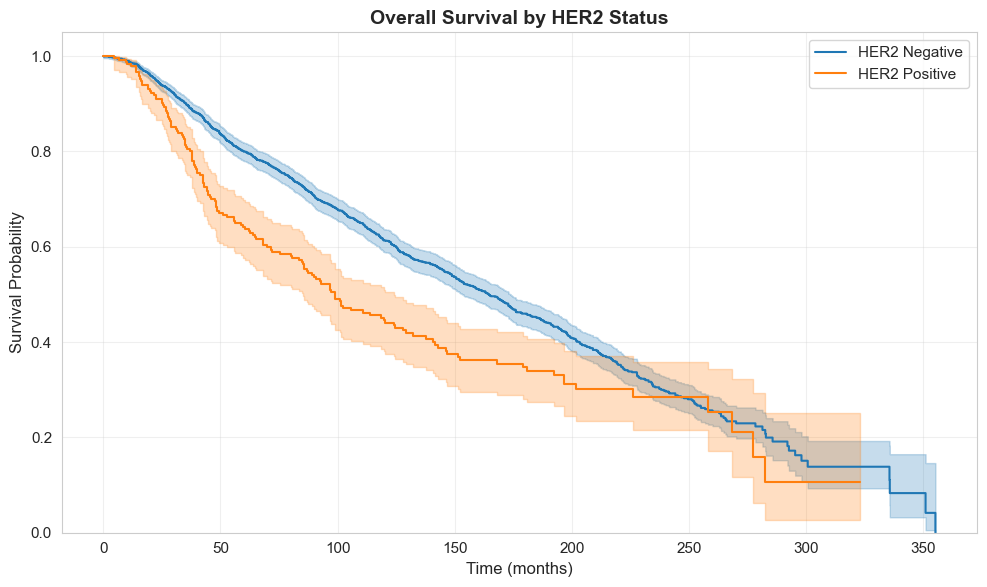

Log-rank test p-value: 0.000009
  → Highly significant difference (p < 0.001)


In [45]:
# 4.4.3 HER2 Status Comparison - Overall Survival (OS)

if 'HER2 Status' in df.columns:
    
    # Check value counts
    print(f"\nHER2 Status distribution:")
    print(df['HER2 Status'].value_counts())
    
    # Create Kaplan-Meier curves and log-rank test
    label_map = {'Positive': 'HER2 Positive', 'Negative': 'HER2 Negative'}
    km_by_group(df, 'HER2 Status', time_col='duration_os', event_col='event_os',
                title='Overall Survival by HER2 Status', label_map=label_map)
else:
    print("HER2 Status column not found in dataset")


Overall survival differed significantly by HER2 status (log-rank p = 0.000009). HER2-negative patients demonstrated substantially better survival, with higher survival probability throughout the entire follow-up period. HER2-positive patients showed poorer long-term survival.


PR Status distribution:
PR Status
Positive    1040
Negative     939
Name: count, dtype: int64


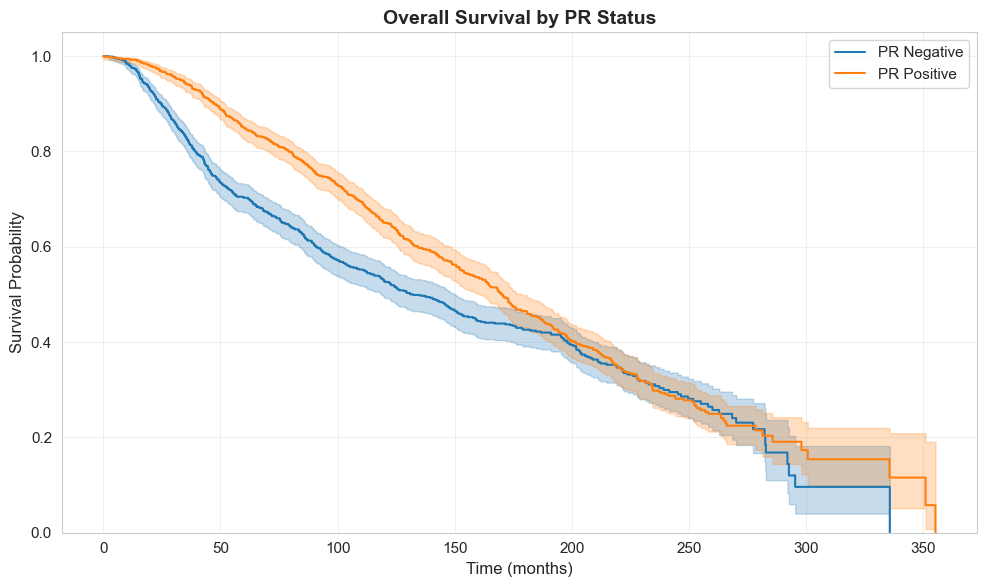

Log-rank test p-value: 0.000083
  → Highly significant difference (p < 0.001)


In [44]:
# 4.4.4 PR Status Comparison - Overall Survival (OS)

if 'PR Status' in df.columns:
    
    # Check value counts
    print(f"\nPR Status distribution:")
    print(df['PR Status'].value_counts())
    
    # Create Kaplan-Meier curves and log-rank test
    label_map = {'Positive': 'PR Positive', 'Negative': 'PR Negative'}
    km_by_group(df, 'PR Status', time_col='duration_os', event_col='event_os',
                title='Overall Survival by PR Status', label_map=label_map)
else:
    print("PR Status column not found in dataset")


verall survival differed significantly according to PR status (log-rank p = 0.000083). Patients with PR-positive tumors had a consistently higher probability of survival compared with PR-negative patients over the entire observation period.
PR-positive tumors generally indicate that the cancer is hormone-driven and may respond better to hormonal (endocrine) therapy, such as tamoxifen or aromatase inhibitors. 


PAM50 Subtype distribution:
Pam50 + Claudin-low subtype
LumA           700
LumB           475
Her2           224
claudin-low    217
Basal          209
Normal         148
NC               6
Name: count, dtype: int64


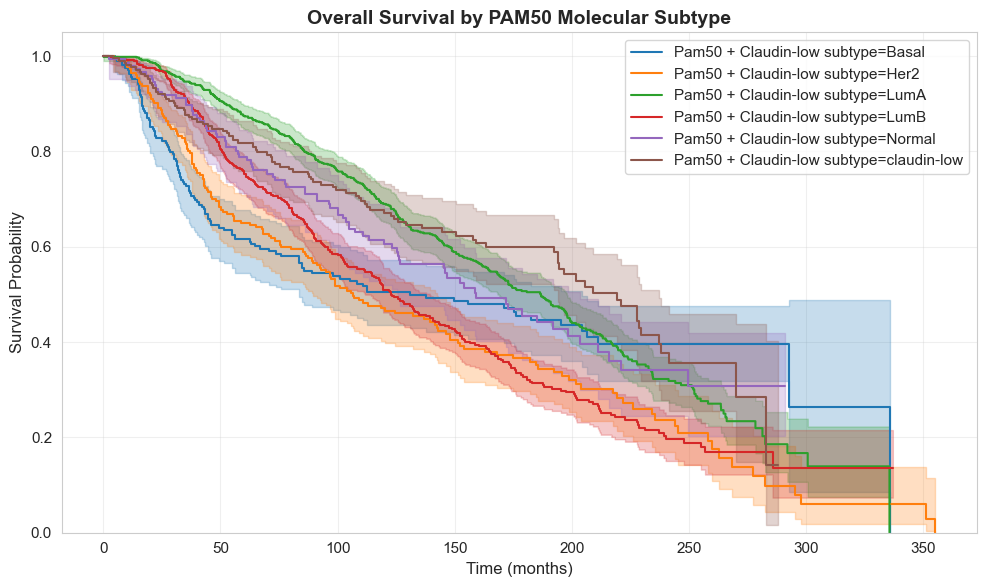

Multigroup log-rank test p-value: 0.000000
  → Highly significant difference (p < 0.001)


In [43]:
# 4.4.5 PAM50 Molecular Subtype Comparison - Overall Survival (OS)

if 'Pam50 + Claudin-low subtype' in df.columns:
    
    # Check value counts
    print(f"\nPAM50 Subtype distribution:")
    print(df['Pam50 + Claudin-low subtype'].value_counts())
    
    # Create Kaplan-Meier curves and log-rank test (multigroup)
    km_by_group(df, 'Pam50 + Claudin-low subtype', 
                time_col='duration_os', event_col='event_os',
                title='Overall Survival by PAM50 Molecular Subtype', 
                min_group_size=10)  # Require at least 10 patients per subtype
else:
    print("PAM50 + Claudin-low subtype column not found in dataset")


Survival varied significantly across PAM50 molecular subtypes (multigroup log-rank p < 0.001). Luminal A tumors showed the most favorable overall survival, followed by the Normal-like subtype. In contrast, Basal-like, HER2-enriched, Claudin-low, and Luminal B subtypes were associated with poorer survival outcomes. These findings confirm that molecular subtype is a strong prognostic factor for overall survival.


### Analysis for RFS for different treatments - LEAVE/ REMOVE ?


In [ ]:
# 4.4.6 Treatment Comparisons - Relapse-Free Survival (RFS)


# Check if RFS data is available
if 'event_rfs' in df.columns and 'duration_rfs' in df.columns:
    # Chemotherapy
    if 'Chemotherapy' in df.columns:
        print("\n" + "="*60)
        print("CHEMOTHERAPY COMPARISON - RELAPSE-FREE SURVIVAL (RFS)")
        print("="*60)
        print(f"\nChemotherapy distribution:")
        print(df['Chemotherapy'].value_counts())
        label_map = {'Yes': 'Chemotherapy', 'No': 'No Chemotherapy'}
        km_by_group(df, 'Chemotherapy', time_col='duration_rfs', event_col='event_rfs',
                    title='Relapse-Free Survival by Chemotherapy Status', label_map=label_map)
    else:
        print("Chemotherapy column not found in dataset")
    
    print("\n" + "="*60)
    
    # Hormone Therapy
    if 'Hormone Therapy' in df.columns:
        print("="*60)
        print("HORMONE THERAPY COMPARISON - RELAPSE-FREE SURVIVAL (RFS)")
        print("="*60)
        print(f"\nHormone Therapy distribution:")
        print(df['Hormone Therapy'].value_counts())
        label_map = {'Yes': 'Hormone Therapy', 'No': 'No Hormone Therapy'}
        km_by_group(df, 'Hormone Therapy', time_col='duration_rfs', event_col='event_rfs',
                    title='Relapse-Free Survival by Hormone Therapy Status', label_map=label_map)
    else:
        print("Hormone Therapy column not found in dataset")
    
    print("\n" + "="*60)
    
    # Radio Therapy
    if 'Radio Therapy' in df.columns:
        print("="*60)
        print("RADIOTHERAPY COMPARISON - RELAPSE-FREE SURVIVAL (RFS)")
        print("="*60)
        print(f"\nRadio Therapy distribution:")
        print(df['Radio Therapy'].value_counts())
        label_map = {'Yes': 'Radiotherapy', 'No': 'No Radiotherapy'}
        km_by_group(df, 'Radio Therapy', time_col='duration_rfs', event_col='event_rfs',
                    title='Relapse-Free Survival by Radiotherapy Status', label_map=label_map)
    else:
        print("Radio Therapy column not found in dataset")
else:
    print("RFS data (event_rfs, duration_rfs) not available for treatment comparisons")


AGE AT DIAGNOSIS COMPARISON - OVERALL SURVIVAL (OS)

Age Group distribution:
Age_Group
<50 years       424
50-70 years    1025
>70 years       531
Name: count, dtype: int64


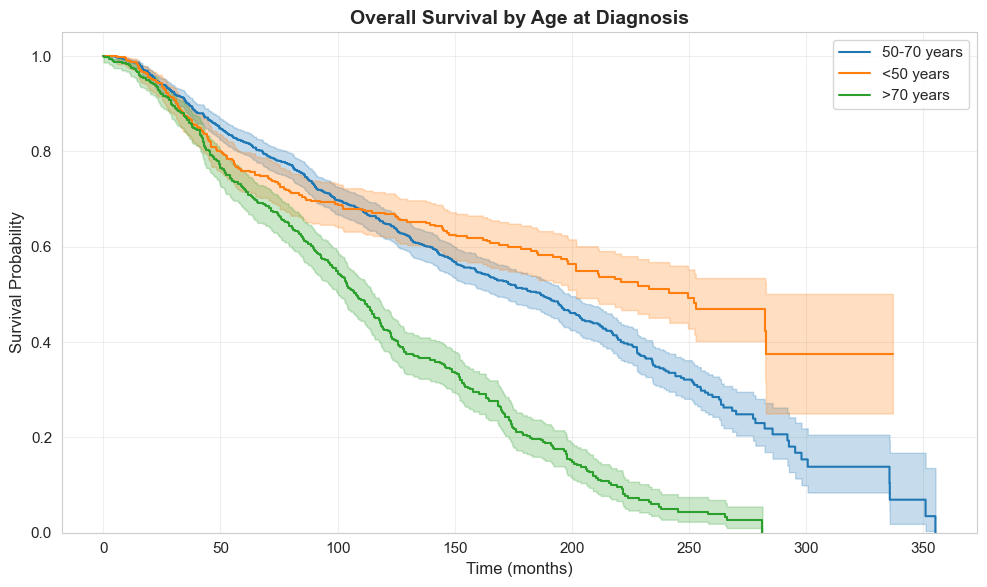

Multigroup log-rank test: p = 0.000000 (Highly significant)


In [48]:
# 4.4.8 Age at Diagnosis Comparison - Overall Survival (OS)

if 'Age at Diagnosis' in df.columns:
    print("="*60)
    print("AGE AT DIAGNOSIS COMPARISON - OVERALL SURVIVAL (OS)")
    print("="*60)
    
    # Create age groups
    df_age = df.copy()
    df_age['Age_Group'] = pd.cut(df_age['Age at Diagnosis'], 
                                  bins=[0, 50, 70, 100], 
                                  labels=['<50 years', '50-70 years', '>70 years'])
    
    # Check value counts
    print(f"\nAge Group distribution:")
    print(df_age['Age_Group'].value_counts().sort_index())
    
    # Create Kaplan-Meier curves and log-rank test (multigroup)
    km_by_group(df_age, 'Age_Group', time_col='duration_os', event_col='event_os',
                title='Overall Survival by Age at Diagnosis', 
                min_group_size=10)
else:
    print("Age at Diagnosis column not found in dataset")


A significant difference in overall survival was observed across age groups (multigroup log-rank test p < 0.001). Patients diagnosed under 50 years demonstrated the best survival outcomes across the follow-up period. Patients aged 50–70 years showed intermediate survival, while those diagnosed over 70 years had markedly poorer survival. These findings suggest that younger patients experience more favorable long-term survival following breast cancer diagnosis compared with older individuals.

INFERRED MENOPAUSAL STATE COMPARISON - OVERALL SURVIVAL (OS)

Menopausal State distribution:
Inferred Menopausal State
Post    1555
Pre      424
Name: count, dtype: int64


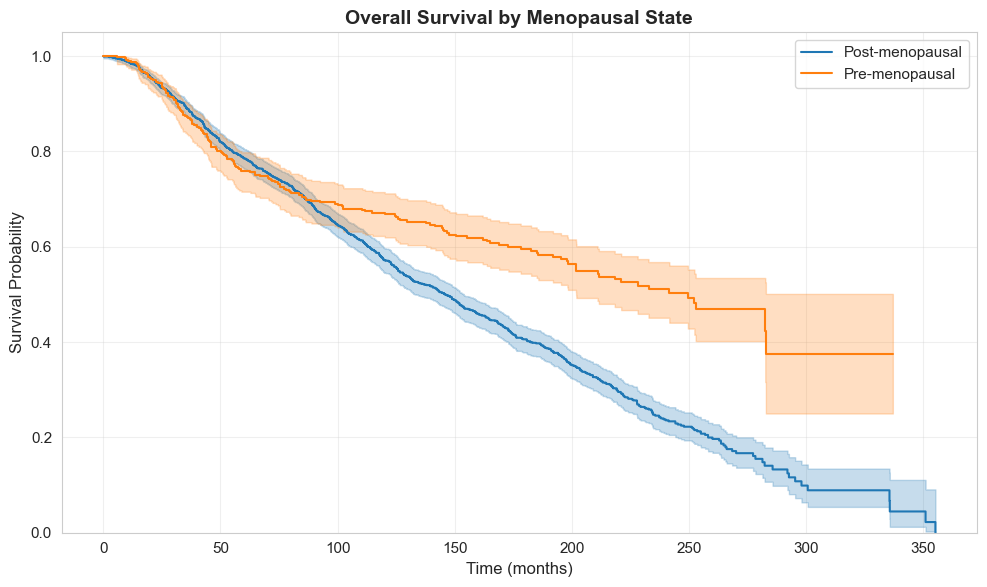

Log-rank test: p = 0.000000 (Highly significant)


In [51]:
# 4.4.10 Inferred Menopausal State Comparison - Overall Survival (OS)

if 'Inferred Menopausal State' in df.columns:
    print("="*60)
    print("INFERRED MENOPAUSAL STATE COMPARISON - OVERALL SURVIVAL (OS)")
    print("="*60)
    
    # Check value counts
    print(f"\nMenopausal State distribution:")
    print(df['Inferred Menopausal State'].value_counts())
    
    # Create Kaplan-Meier curves and log-rank test
    label_map = {'Pre': 'Pre-menopausal', 'Post': 'Post-menopausal'}
    km_by_group(df, 'Inferred Menopausal State', time_col='duration_os', event_col='event_os',
                title='Overall Survival by Menopausal State', label_map=label_map)
else:
    print("Inferred Menopausal State column not found in dataset")


Pre-menopausal women had consistently better survival outcomes across the entire follow-up period compared to post-menopausal women. The log-rank test confirmed a highly significant difference between the two groups (p < 0.001), indicating that menopausal state is a meaningful prognostic factor for overall survival.

In [60]:
# 4.4.11 Primary Tumor Laterality Comparison - Overall Survival (OS)

if 'Primary Tumor Laterality' in df.columns:
    print("="*60)
    print("PRIMARY TUMOR LATERALITY COMPARISON - OVERALL SURVIVAL (OS)")
    print("="*60)
    
    # Check value counts
    print(f"\nTumor Laterality distribution:")
    print(df['Primary Tumor Laterality'].value_counts())
    
    # Create Kaplan-Meier curves and log-rank test
    label_map = {'Left': 'Left breast', 'Right': 'Right breast'}
    km_by_group(df, 'Primary Tumor Laterality', time_col='duration_os', event_col='event_os',
                title='Overall Survival by Primary Tumor Laterality', label_map=label_map)
else:
    print("Primary Tumor Laterality column not found in dataset")


Primary Tumor Laterality column not found in dataset


The two groups demonstrated nearly overlapping survival trajectories, indicating comparable overall survival regardless of tumor laterality. Since the variable does not contribute useful predictive information and does not affect survival, including it in further modelling would add noise rather than value. 

 -> Therefore, tumor laterality can be safely excluded from subsequent analyses.

In [61]:
# Drop Primary Tumor Laterality (non-predictive based on KM analysis above)
# The two groups demonstrated nearly overlapping survival trajectories, 
# indicating comparable overall survival regardless of tumor laterality.

if 'Primary Tumor Laterality' in df.columns:
    print("="*60)
    print("REMOVING PRIMARY TUMOR LATERALITY")
    print("="*60)
    print("\nReason: Overlapping survival trajectories observed in KM analysis above")
    print("       (comparable overall survival regardless of tumor laterality)")
    
    n_before = len(df.columns)
    df = df.drop(columns=['Primary Tumor Laterality'])
    n_after = len(df.columns)
    
    print(f"\n✓ Removed 'Primary Tumor Laterality' column")
    print(f"  Columns: {n_before} → {n_after}")
else:
    print("'Primary Tumor Laterality' column not found in dataset (may have been removed earlier)")


'Primary Tumor Laterality' column not found in dataset (may have been removed earlier)


## 5. Preprocessing and Data Splitting for Modeling


- **Leakage control**: Remove outcome columns and identifiers from features
- **Train/validation/test splits**: Create stratified splits (60/20/20) for model evaluation
- **Preprocessing pipeline**: Build and fit preprocessing (imputation, encoding, scaling) on training data only
- **Data transformation**: Apply preprocessing to all splits without leakage



### 5.1 Leakage Control Strategy

**Leakage controls implemented:**


**Variables to EXCLUDE:**
- `Patient ID` (identifier, may use for grouping)
- `Overall Survival (Months)` (direct outcome)
- `Overall Survival Status` (direct outcome)
- `Relapse Free Status (Months)` (if using OS as outcome)
- `Relapse Free Status` (if using OS as outcome)
- `Patient's Vital Status` (likely redundant with OS status)
- Any variables derived from outcomes or measured post-treatment


In [ ]:
# 5.1 Define Columns to Drop (Leakage Control)

# Columns that directly contain outcome information (LEAKAGE)
# Original column names from the dataset
OUTCOME_COLS = [
    "Overall Survival (Months)",
    "Overall Survival Status", 
    "Relapse Free Status (Months)",
    "Relapse Free Status",
    "Patient's Vital Status"
]

# Standardized outcome columns we created (also need to be excluded!)
STANDARDIZED_OUTCOME_COLS = [
    "duration_os",      # Duration for Overall Survival - OUTCOME!
    "duration_rfs",     # Duration for Relapse-Free Survival - OUTCOME!
    "event_os",         # Event indicator for OS - OUTCOME! (but we keep it in y)
    "event_rfs"         # Event indicator for RFS - OUTCOME!
]

# Identifier column (keep for grouping but exclude from features)
ID_COL = "Patient ID"

# Combine all columns to drop (original + standardized outcome columns)
cols_to_drop = []
cols_to_drop.extend([col for col in OUTCOME_COLS + [ID_COL] if col in df.columns])
cols_to_drop.extend([col for col in STANDARDIZED_OUTCOME_COLS if col in df.columns])

print("Columns to exclude from features (leakage control):")
print("\nOriginal outcome columns:")
for col in OUTCOME_COLS:
    if col in df.columns:
        print(f"  - {col}")

print("\nStandardized outcome columns (created in cell 7):")
for col in STANDARDIZED_OUTCOME_COLS:
    if col in df.columns:
        print(f"  - {col}")

if ID_COL in df.columns:
    print(f"\nIdentifier column:")
    print(f"  - {ID_COL}")

# Create X (features) and y (outcome) dataframes
# Note: event_os and duration_os are kept in y but removed from X
X = df.drop(columns=cols_to_drop, errors='ignore').copy()
y = df[["duration_os", "event_os"]].copy()

print(f"\n✓ Removed {len(cols_to_drop)} outcome/identifier columns from features")

# Also store patient IDs for group-aware splitting if needed
patient_ids = df[ID_COL].values if ID_COL in df.columns else None

print(f"\nFeature matrix shape: {X.shape}")
print(f"Outcome matrix shape: {y.shape}")



In [ ]:
# 5.2 Create stratified train, validation, and test splits re-used across all models

def make_splits(X: pd.DataFrame, y: pd.Series, seed: int = 42):
    """
    Create stratified train/validation/test splits (60/20/20).
    """
    # First split off test 20 percent
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=seed)
    train_val_idx, test_idx = next(sss1.split(X, y))
    X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]

    # Split train vs validation 75:25 within the remaining 80 percent to yield 60:20:20 overall
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=seed)
    train_idx, val_idx = next(sss2.split(X_train_val, y_train_val))

    idx_train = X_train_val.index[train_idx]
    idx_val = X_train_val.index[val_idx]
    idx_test = X_test.index

    return idx_train, idx_val, idx_test

# Create splits using event_os for stratification
idx_train, idx_val, idx_test = make_splits(X, y["event_os"], seed=SEED)

print("Split sizes",
      "train", len(idx_train),
      "val", len(idx_val),
      "test", len(idx_test))

# Materialize split datasets
X_train, X_val, X_test = X.loc[idx_train], X.loc[idx_val], X.loc[idx_test]
y_train, y_val, y_test = y.loc[idx_train], y.loc[idx_val], y.loc[idx_test]

# Display split information
print(f"Train set:      {len(X_train):4d} samples ({len(X_train)/len(X)*100:5.1f}%)")
print(f"Validation set: {len(X_val):4d} samples ({len(X_val)/len(X)*100:5.1f}%)")
print(f"Test set:       {len(X_test):4d} samples ({len(X_test)/len(X)*100:5.1f}%)")
print(f"Total:          {len(X):4d} samples")

# Check event rates across splits
print("\n" + "="*60)
print("EVENT RATES ACROSS SPLITS")
print("="*60)
event_rate_train = y_train["event_os"].mean()
event_rate_val = y_val["event_os"].mean()
event_rate_test = y_test["event_os"].mean()
print(f"Train:      {event_rate_train*100:5.1f}% ({y_train['event_os'].sum():3d} events)")
print(f"Validation: {event_rate_val*100:5.1f}% ({y_val['event_os'].sum():3d} events)")
print(f"Test:       {event_rate_test*100:5.1f}% ({y_test['event_os'].sum():3d} events)")


### 5.3 Feature Type Detection and Preprocessing Pipeline

1. **Feature Type Detection**
   - Automatically identifies which features are categorical (discrete categories) vs numeric (continuous numbers)
   - Categorical features: text/object types or integers with few unique values
   - Numeric features: continuous variables like age, tumor size, mutation count

2. **Preprocessing Pipeline Construction**
   - Creates separate transformation pipelines for categorical and numeric features
   - **Numeric pipeline**: Imputes missing values with median → Standardizes (z-score normalization)
   - **Categorical pipeline**: Imputes missing values with most frequent category → One-hot encodes

3. **Leakage Prevention**
   - Pipeline is fitted on training data
   - Validation and test sets are transformed using parameters learned from training


In [ ]:
# 5.3 Feature Type Detection and Preprocessing Pipeline

def detect_feature_types(X):
    # Identify categorical columns (object type or with few unique values)
    cat_cols = []
    num_cols = []
    
    for col in X.columns:
        if X[col].dtype == 'object':
            cat_cols.append(col)
        elif X[col].dtype in ['int64', 'float64']:
            # Consider low-cardinality integer columns as categorical if they have few unique values
            n_unique = X[col].nunique()
            if n_unique <= 10 and n_unique < len(X) * 0.05:  # Less than 5% unique values
                cat_cols.append(col)
            else:
                num_cols.append(col)
        else:
            # Default to numeric for other types
            num_cols.append(col)
    
    return cat_cols, num_cols


# Detect feature types from training data
cat_cols, num_cols = detect_feature_types(X_train)

print("="*60)
print("FEATURE TYPE DETECTION")
print("="*60)
print(f"Categorical features: {len(cat_cols)}")
print(f"Numeric features:     {len(num_cols)}")

if len(cat_cols) > 0:
    print(f"\nCategorical features (first 10):")
    for col in cat_cols[:10]:
        n_unique = X_train[col].nunique()
        n_missing = X_train[col].isnull().sum()
        print(f"  {col:40s} - {n_unique:3d} unique values, {n_missing:4d} missing")

if len(num_cols) > 0:
    print(f"\nNumeric features (first 10):")
    for col in num_cols[:10]:
        n_missing = X_train[col].isnull().sum()
        mean_val = X_train[col].mean()
        print(f"  {col:40s} - {n_missing:4d} missing, mean={mean_val:.2f}")

# 4.5 Build Consolidated Preprocessing Pipeline

# Numeric feature pipeline
# - Impute missing values with median (fit on train only)
# - Standardize to zero mean and unit variance (fit on train only)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical feature pipeline
# - Impute missing values with most frequent category (fit on train only)
# - One-hot encode (fit on train only, ignore unknown categories at transform time)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

# Combined preprocessor
# This ensures all transformations are fit on training data only
# and applied consistently to validation and test sets
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop',  # Drop any columns not explicitly handled
    verbose_feature_names_out=False  # Keep original feature names where possible
)


# Fit preprocessor on training data only
preprocessor.fit(X_train)

# Transform all splits
X_train_transformed = preprocessor.transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

print(f"\nTransformed feature dimensions:")
print(f"  Train:      {X_train_transformed.shape}")
print(f"  Validation: {X_val_transformed.shape}")
print(f"  Test:       {X_test_transformed.shape}")

# Create transformed DataFrames for convenience
# Convert to DataFrame if not already (when set_config is used)
if hasattr(X_train_transformed, 'columns'):
    Xt_train = X_train_transformed
    Xt_val = X_val_transformed
    Xt_test = X_test_transformed
else:
    # Convert numpy arrays to DataFrames with feature names
    try:
        feature_names = preprocessor.get_feature_names_out()
        Xt_train = pd.DataFrame(X_train_transformed, 
                                index=X_train.index, 
                                columns=feature_names)
        Xt_val = pd.DataFrame(X_val_transformed, 
                             index=X_val.index, 
                             columns=feature_names)
        Xt_test = pd.DataFrame(X_test_transformed, 
                               index=X_test.index, 
                               columns=feature_names)
    except:
        # Fallback if feature names not available
        Xt_train = pd.DataFrame(X_train_transformed, index=X_train.index)
        Xt_val = pd.DataFrame(X_val_transformed, index=X_val.index)
        Xt_test = pd.DataFrame(X_test_transformed, index=X_test.index)

print(f"Transformed DataFrames created:")
print(f"  Xt_train: {Xt_train.shape}")
print(f"  Xt_val:   {Xt_val.shape}")
print(f"  Xt_test:  {Xt_test.shape}")

